In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import time
import copy
from scipy.signal import find_peaks, resample
from icecream import ic
from collections import OrderedDict

from neurolib.models.aln import ALNModel
#from neurolib.models.aln import ALNModel_SaveSteps
import neurolib.utils.stimulus as stim
import neurolib.utils.functions as func  
from neurolib.utils.parameterSpace import ParameterSpace
from neurolib.optimize.exploration import BoxSearch
import os
import sys
#from pynverse import inversefunc

#from intersect import intersection
from scipy.stats import mode


sys.path.insert(0, '..')
from prc_funcs import *
from functions import *
    

import matplotlib.colors as mcolors

colors = mcolors.TABLEAU_COLORS
by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(color))),
                         name)
                        for name, color in colors.items())
colrs = [name for hsv, name in by_hsv]

#hide
import logging
logging.getLogger().setLevel(logging.INFO)
import warnings
warnings.filterwarnings("ignore")

BASE_PATH = "../../../../" # need to go back from default hdf path "./data/hdf"
HDF_PATH = BASE_PATH + "Data/"

## Plot of Phases and Periods predicted by PRC

## Ke = 50

In [2]:
sampling = 1
aln = ALNModel()
aln.params['mue_ext_mean'] = 1.1
aln.params['mui_ext_mean'] = 0.5
aln.params['dt'] = 0.01
#aln.params['dt'] = 0.002
aln.params['sampling_dt'] = aln.params.dt * sampling
aln.params['a'] = 0.
aln.params['b'] = 0.
aln.params['sigma_ou'] = 0.
#aln.params['Ke_gl'] = 30.
prc = PRC_ALN(aln)

INFO:root:aln: Model initialized.
ic| domfreq: 21.50526315789473


initialised ...


In [89]:
#prc.calc_prc_xcorr(
#    itype="real", 
#    Ke_gl=50, 
#    num_points=1000)

100%|██████████| 1000/1000 [1:41:03<00:00,  6.06s/it]


In [3]:
#np.save('../data/PRC_real_Kegl=50_highres.npy', prc.prc_xcorr) 
prc_xcorr = np.load('data/PRC_real_Kegl=50_highres.npy',allow_pickle='TRUE').item()

In [4]:
def lambda_factory(ab):
    return lambda x:x*ab[0]+ab[1]

def broken_line(x, x0, y0):
    cl = []
    fl = []
    for i in range(len(x0)-1):
        ab = np.polyfit(x0[i:i+2], y0[i:i+2], 1)
        #ic(ab)
        # Compute and append a "condition" interval
        cl.append(np.logical_and(x >= x0[i], x <= x0[i+1]))
        # Create a line function for the interval
        fl.append(lambda_factory(ab))
    return(np.piecewise(x, condlist=cl, funclist=fl))


def f1(x):
    return broken_line(x, x1, y1)

def f2(x):
    return broken_line(x, x2[::-1], y2[::-1])

def f(xy):
    x, y = xy
    z = np.array([y - f1(x), y - f2(x)])
    return z

In [5]:
period_fr = prc.frperiod
phis = np.asarray(list(prc_xcorr.keys()))
prcs = np.asarray(list(prc_xcorr.values()))

# Have a data point for phi=0 and phi=T
phis = np.concatenate(([0.], phis))
phis = np.concatenate((phis, [period_fr]))
prcs = np.concatenate(([np.mean((prcs[0], prcs[-1]))], prcs))
prcs = np.concatenate((prcs, [np.mean((prcs[0], prcs[-1]))]))
def prc_func(x):
    return broken_line(x, phis, prcs) 

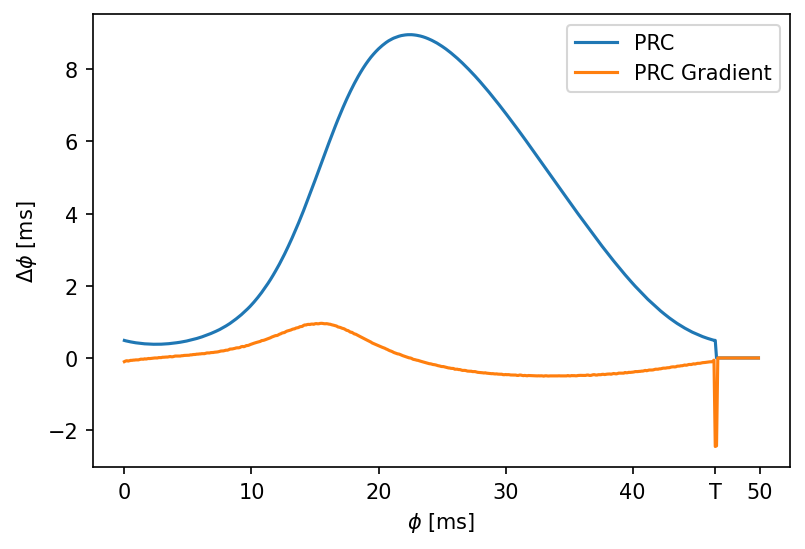

In [6]:
fig, ax = plt.subplots(dpi=150)
xs = np.arange(0, 50, 0.1,)
ax.plot(xs, prc_func(xs), label="PRC")
ax.plot(xs, np.gradient(prc_func(xs), xs), label="PRC Gradient")
# set ticks and tick labels
ax.set_xticks([0, 10, 20, 30, 40, 50, prc.frperiod])
ax.set_xticklabels(labels=['0', '10', '20', '30', '40', '50', 'T'] )
ax.set_xlabel(r"$\phi$ [ms]")
ax.set_ylabel(r"$\Delta \phi$ [ms]")
ax.legend()

## try simple inversion method 

In [94]:
States = {}    
# in-phase sync
States["in_s_p"] = [] # stable
States["in_u_p"] = [] # unstable
# anti-phase sync
States["anti_s_p"] = []
States["anti_u_p"] = []
# out-of-phase sync
States["oop_s_p1"] = []
States["oop_s_p2"] = []
States["oop_u_p1"] = []
States["oop_u_p2"] = []
# in-phase sync
States["in_s_d"] = [] # stable
States["in_u_d"] = [] # unstable
# anti-phase sync
States["anti_s_d"] = []
States["anti_u_d"] = []
# out-of-phase sync
States["oop_s_d"] = []
States["oop_u_d"] = []

delays = np.arange(0, 3*prc.frperiod, 0.1)
States["delays"] = delays

def n(phi):
    return phi%prc.frperiod + prc_func(phi%prc.frperiod)
invN = inversefunc(n)

for d in tqdm(delays):   
    for k in [1, 2, 3, 4, 5, 6, 7, 8]:
        #if k != 1:
        #    def mk(phi):
        #        return (phi%prc.frperiod)/(k-1) - prc_func(phi%prc.frperiod)
        #    invMk = inversefunc(mk)
                   
        x1 = phis + (k-1) * (prc.frperiod - prcs)
        y1 = 2 * d + prc.frperiod - phis - prcs

        x2 = 2 * d + prc.frperiod - phis - prcs
        y2 = phis + (k-1) * (prc.frperiod - prcs)

        x,y = intersection(x1, y1, x2, y2)

        if len(x) == 0:
            continue
        #ic(d, k, x, y)
        for i in range(len(x)):
            if k == 1:
                phi1 = x[i]
                phi2 = y[i]
            else:
                phi1 = invN(2 * d - x[i] + prc.frperiod) % prc.frperiod
                phi2 = invN(2 * d - y[i] + prc.frperiod) % prc.frperiod
                
                #phi1 = invMk(x[i] / (k-1) - prc.frperiod) % prc.frperiod
                #phi2 = invMk(y[i] / (k-1) - prc.frperiod) % prc.frperiod
                

            ## find slope of PRC at intersection phases
            xs = np.arange(phi1-0.01, phi1+0.01, 0.001)
            m1 = np.gradient(prc_func(xs), xs)[10] # this could misbehaves at end of PRC -> jump to 0
            xs = np.arange(phi2-0.01, phi2+0.01, 0.001)
            m2 = np.gradient(prc_func(xs), xs)[10]

            if k == 1:
                eigenv = (m1 + 1) * (m2 + 1)
            elif k == 2:
                eigenv = (m1 + 1) * (m2 + 1) - m1 * m2 
            else:
                # construct mapping matrix
                A = np.zeros((k-1, k-1))
                A[0][0] = (m1 + 1) * (m2 + 1) - m1 * m2
                # fill 1. row with -m1m2
                for j in range(1, k-1):
                    A[0][j] = - m1 * m2
                # fill appropiate 1s for system of eqs. 
                for j in range(k-1):
                    if j == 0:
                        pass
                    else:
                        A[j][j-1] = 1

                eigenvs = np.linalg.eig(A)[0]
                eigenv = np.max(np.real(eigenvs))
            if not np.isclose(phi1, phi2, atol=0.1):
                if eigenv < 1:  
                    States["oop_s_d"].append(d)
                    # bigger value into phi1, smaller into phi2
                    States["oop_s_p1"].append(max(phi1, phi2))
                    States["oop_s_p2"].append(min(phi1, phi2))
                else:
                    States["oop_u_d"].append(d)
                    States["oop_u_p1"].append(max(phi1, phi2))
                    States["oop_u_p2"].append(min(phi1, phi2))
                    
            elif (k%2) == 0: # in-phase
                if eigenv < 1:
                    States["in_s_d"].append(d)
                    States["in_s_p"].append(phi1)
                else:
                    States["in_u_d"].append(d)
                    States["in_u_p"].append(phi1)
            else:
                if eigenv < 1:
                    States["anti_s_d"].append(d)
                    States["anti_s_p"].append(phi1)
                else:
                    States["anti_u_d"].append(d)
                    States["anti_u_p"].append(phi1)
                    
            

 70%|███████   | 982/1394 [2:52:13<1:12:15, 10.52s/it]


ValueError: arange: cannot compute length

In [7]:
#np.save('../data/States_from_PRC_Ke_gl=50.npy', States) 
States = np.load('data/States_from_PRC_Ke_gl=50.npy',allow_pickle='TRUE').item()

## There is sometimes a phase found by the inversion which is sllightly higher than frperiod (prc-func is 0 at higher values)
## Next time, check in computation if found phase is in valid range
## For now, just cut :D

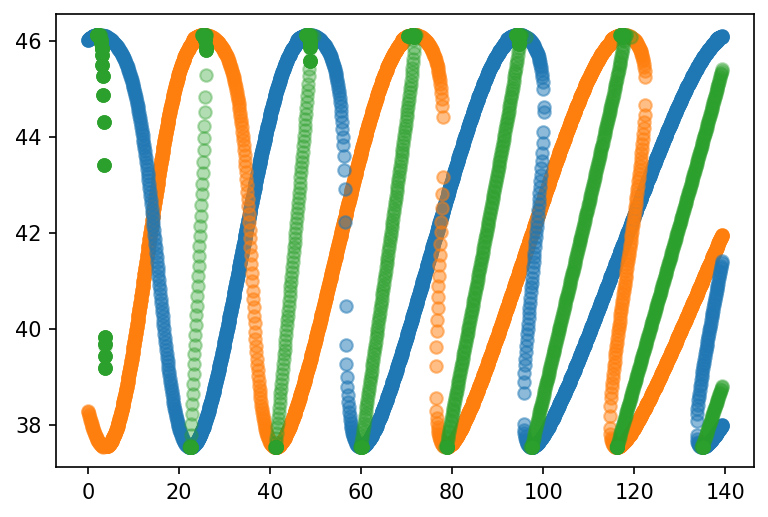

In [8]:
fig, ax = plt.subplots(dpi=150)
plt.scatter(States["in_s_d"], prc.frperiod - prc_func(States["in_s_p"]), c="tab:blue")
plt.scatter(States["anti_s_d"], prc.frperiod - prc_func(States["anti_s_p"]), c="tab:orange")
plt.scatter(States["in_u_d"], prc.frperiod - prc_func(States["in_u_p"]), c="tab:blue", alpha=0.5)
plt.scatter(States["anti_u_d"], prc.frperiod - prc_func(States["anti_u_p"]), c="tab:orange", alpha=0.5)
plt.scatter(States["oop_s_d"], prc.frperiod - prc_func(States["oop_s_p1"]), c="tab:green")
plt.scatter(States["oop_u_d"], prc.frperiod - prc_func(States["oop_u_p1"]), c="tab:green", alpha=0.2)


## now turn the scatter points into smooth branches

In [9]:
def find_branches(delays, phis, dis=10):
    '''
    Turns set of points on branches into smooth branches-lines. Do this by sorting by (x+y)**3 to split branches.
    '''
    delays = np.asarray(delays)
    phis = np.asarray(phis)
    prcs = prc_func(phis)
    #phis = prc_func(np.asarray(phis))
    d_step = mode(np.diff(np.unique(delays)))[0][0] # find stepsize in delay parameter
    branches = []
      
    # 1. rearrange indices in branches, s.t. sorts by branch that could overlab (bistability)
    # this will remove the jumps and create a smooth curve since most are unique in phi but not in d
    sort = np.argsort((delays + prcs)**3)
    delays = delays[sort]
    phis = phis[sort]
    prcs = prcs[sort]
    
    #return [delays, phis]
    j = 0
    for i in range(len(delays)-1):
        if np.sqrt((delays[i+1] - delays[i])**3 + (prcs[i+1] - prcs[i])**3) > dis:
            branches.append([delays[j:i+1], prcs[j:i+1], phis[j:i+1]])
            j = i+1
            
    branches.append([delays[j:-1], prcs[j:-1], phis[j:-1]])
    
    ic(len(branches))
    
    for i in range(len(branches)):
        x = branches[i][0]
        y = branches[i][1]
        z = branches[i][2]
        sort = np.argsort(y)
        branches[i] = (x[sort], y[sort], z[sort])
        
    return branches

ic| len(branches): 4
ic| len(branches): 5
ic| len(branches): 4
ic| len(branches): 5
ic| len(branches): 9
ic| len(branches): 13


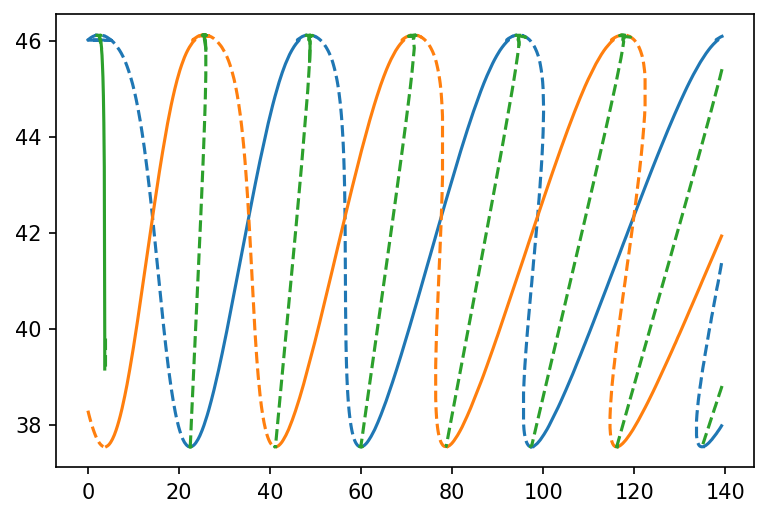

In [10]:
fig, ax = plt.subplots(dpi=150)

branches = find_branches(States['in_u_d'], States['in_u_p'])
for br in branches:
    plt.plot(br[0], prc.frperiod - br[1], "--", c = "tab:blue")
    
branches = find_branches(States['in_s_d'], States['in_s_p'])
for br in branches:
    plt.plot(br[0], prc.frperiod - br[1], "-", c="tab:blue")
    
branches = find_branches(States['anti_u_d'], States['anti_u_p'])
for br in branches:
    plt.plot(br[0], prc.frperiod - br[1], "--", c = "tab:orange")

branches = find_branches(States['anti_s_d'], States['anti_s_p'], dis=0.1)
for br in branches:   
    plt.plot(br[0], prc.frperiod - br[1], "-", c="tab:orange")
    
    
branches = find_branches(States['oop_u_d'], States['oop_u_p1'])
#ic(len(branches))
for br in branches:
    plt.plot(br[0], prc.frperiod - br[1], "--", c = "tab:green")


branches = find_branches(States['oop_s_d'], States['oop_s_p2'], dis=10)
for br in branches:   
    plt.plot(br[0], prc.frperiod - br[1], "-", c="tab:green")
#plt.plot(branches[1][0], branches[1][1], "-", c="tab:orange")
#plt.xlim(70, 100)

## with my style

ic| len(branches): 4
ic| len(branches): 5
ic| len(branches): 4
ic| len(branches): 4
ic| len(branches): 9
ic| len(branches): 13


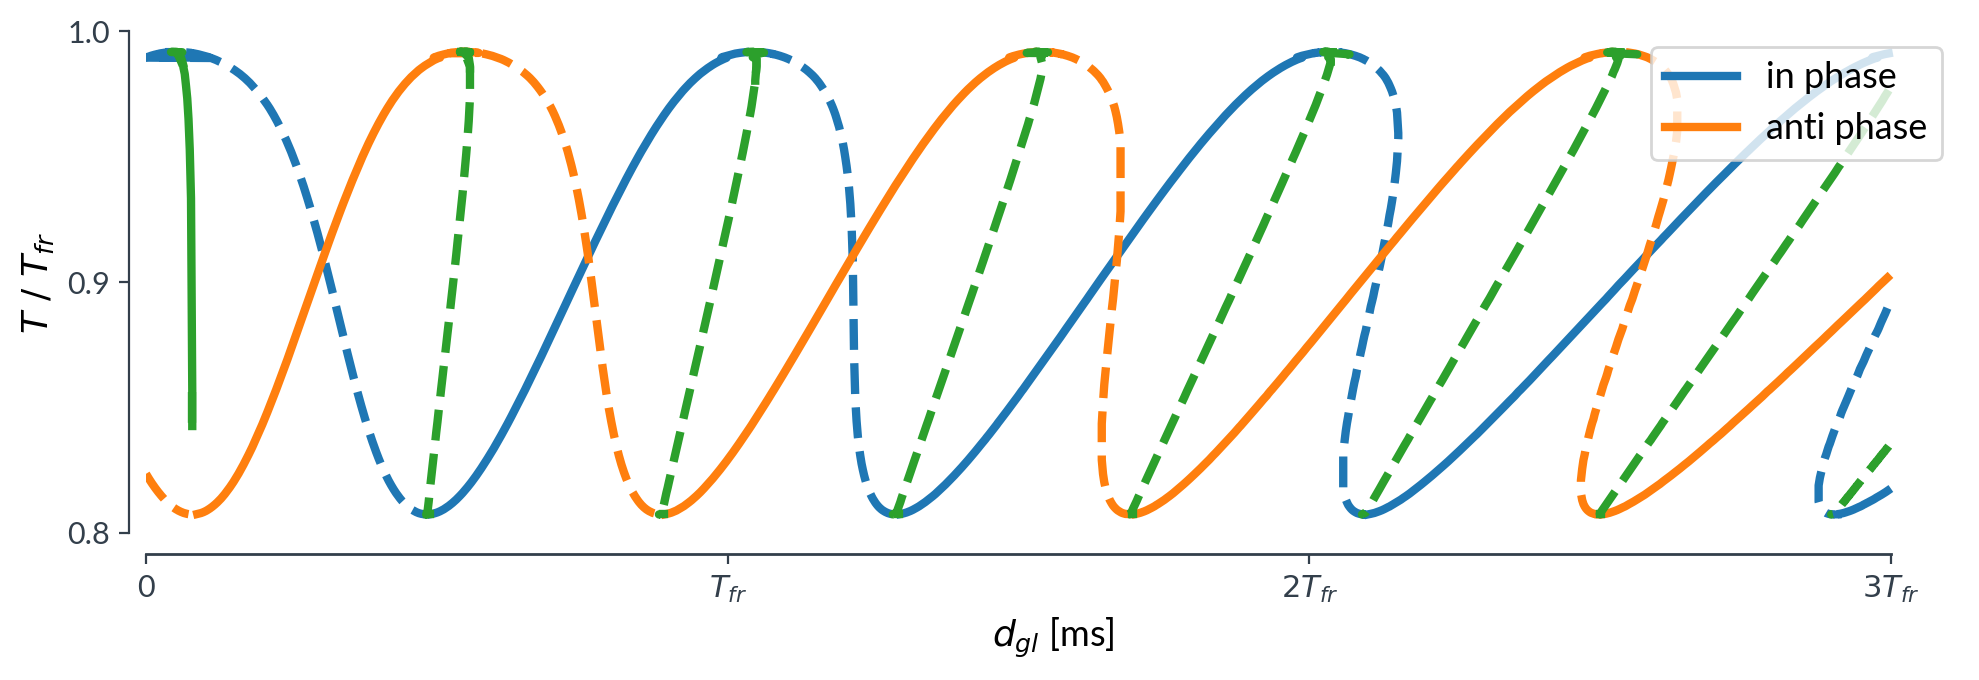

In [11]:
plt.rcParams['font.family'] = 'Lato'
plt.rcParams['font.sans-serif'] = 'Lato'
plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'
plt.rcParams['axes.labelsize']=13
plt.rcParams['xtick.labelsize']=11
plt.rcParams['ytick.labelsize']=11
plt.rcParams['legend.fontsize'] = 13

def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    handles, labels = [*zip(*unique)]
    ax.legend(handles, labels, loc="upper right")

fig, ax = plt.subplots(1,1, figsize=(10, 3.5), dpi=200, sharex=True)

branches = find_branches(States['in_u_d'], States['in_u_p'])
for br in branches:
    ax.plot(br[0], (prc.frperiod - br[1])/prc.frperiod, "--", c = "tab:blue", lw=3)
    
branches = find_branches(States['in_s_d'], States['in_s_p'])
for br in branches:
    ax.plot(br[0], (prc.frperiod - br[1])/prc.frperiod, "-", c="tab:blue", lw=3, label="in phase")
    
branches = find_branches(States['anti_u_d'], States['anti_u_p'])
for br in branches:
    ax.plot(br[0], (prc.frperiod - br[1])/prc.frperiod, "--", c = "tab:orange", lw=3)

branches = find_branches(States['anti_s_d'], States['anti_s_p'])
for br in branches:   
    ax.plot(br[0], (prc.frperiod - br[1])/prc.frperiod, "-", c="tab:orange", lw=3, label="anti phase")
    
    
branches = find_branches(States['oop_u_d'], States['oop_u_p1'])
#ic(len(branches))
for br in branches:
    ax.plot(br[0], (prc.frperiod - br[1])/prc.frperiod, "--", c = "tab:green", lw=3)


branches = find_branches(States['oop_s_d'], States['oop_s_p1'])
for br in branches:   
    ax.plot(br[0], (prc.frperiod - br[1])/prc.frperiod, "-", c="tab:green", lw=3)
    
#ax.text(prc.frperiod/2, 0, r'$k = 1$', size=13)
#ax.text(3*prc.frperiod/2, 0, r'$k = 2$', size=13)
#ax.text(5*prc.frperiod/2, 0, r'$k = 3$', size=13)

#ax.axvline(prc.frperiod, c="grey", lw=2)

#ax.axvline(2*prc.frperiod, c="grey", lw=2)



ax.set_ylabel(r"$T \ / \ T_{fr}$")
ax.set_xlabel(r"$d_{gl}$ [ms]")

ax.set_xlim(0, 145)


ax.set_xticks([0, prc.frperiod, 2*prc.frperiod, 3*prc.frperiod])
ax.set_xticklabels(labels=['0', r'$T_{fr}$', r'$2T_{fr}$', r'$3T_{fr}$'])


ax.set_yticks([0.8, 0.9, 1])
ax.set_yticklabels(['0.8', '0.9', '1.0'])

ax.tick_params(right=False, top=False)

ax.spines["top"].set_visible(False), ax.spines["right"].set_visible(False)

plt.draw()

lab = [float(item.get_text().replace("−", "-")) for item in ax.get_yticklabels(which='both')]
ax.spines["left"].set_bounds(low=min(lab), high=max(lab))
ax.spines["left"].set_position(("outward", 6))

ax.spines["bottom"].set_bounds(low=0, high=3*prc.frperiod)
ax.spines["bottom"].set_linewidth(1)
ax.spines["bottom"].set_position(("outward",6))



#axs[0].set_title("Kegl = 50")
legend_without_duplicate_labels(ax)
fig.tight_layout()
#fig.savefig("Pics/Two_Node_Phases_Periods_all.pdf")

# show phases
### to avoid vertical segment in phase branches we resort the branches and cut on a big jump

In [12]:
def find_branches_phases(delays, phis, dis=10):
    delays = np.asarray(delays)
    phis = np.asarray(phis)
    prcs = prc_func(phis)
    #phis = prc_func(np.asarray(phis))
    d_step = mode(np.diff(np.unique(delays)))[0][0] # stepsize in delay parameter
    ic(d_step)
    branches = []
      
    # 1. rearrange indices in branches, s.t. sorts by branch that could overlab (bistability)
    # this will remove the jumps and create a smooth curve since most are unique in phi but not in d
    sort = np.argsort((delays + prcs)**3)
    delays = delays[sort]
    phis = phis[sort]
    prcs = prcs[sort]
    
    #return [delays, phis]
    j = 0               
    for i in range(len(delays)-1):
        if (np.sqrt((delays[i+1] - delays[i])**3 + (prcs[i+1] - prcs[i])**3) > dis):
            branches.append([delays[j:i+1], prcs[j:i+1], phis[j:i+1]])
            j = i+1
            
    branches.append([delays[j:-1], prcs[j:-1], phis[j:-1]])
    
    ic(len(branches))
    
    for i in range(len(branches)):
        x = branches[i][0]
        y = branches[i][1]
        z = branches[i][2]
        sort = np.argsort(z)
        branches[i] = (x[sort], y[sort], z[sort])
        
            
    return branches

ic| d_step: 0.10000000000000142
ic| len(branches): 5
ic| d_step: 0.09999999999999432
ic| len(branches): 6
ic| d_step: 0.10000000000000142
ic| len(branches): 4
ic| d_step: 0.09999999999999432
ic| len(branches): 5
ic| d_step: 0.09999999999999432
ic| len(branches): 9
ic| d_step: 0.09999999999999432
ic| len(branches): 9
ic| d_step: 0.10000000000000009
ic| len(branches): 13
ic| d_step: 0.10000000000000009
ic| len(branches): 13


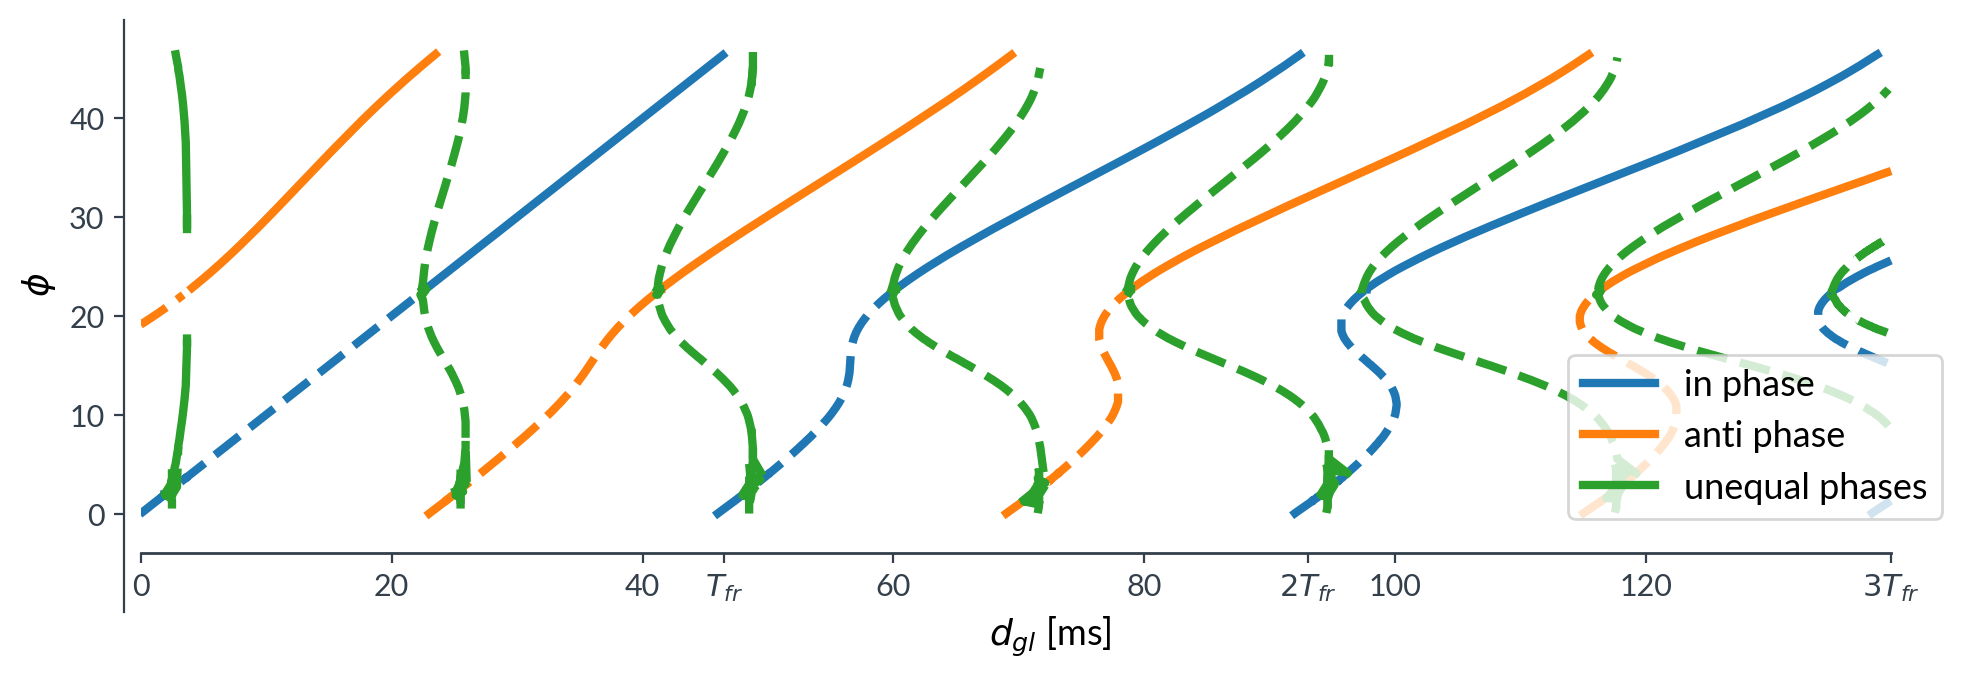

In [13]:
plt.rcParams['font.family'] = 'Lato'
plt.rcParams['font.sans-serif'] = 'Lato'
plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'
plt.rcParams['axes.labelsize']=13
plt.rcParams['xtick.labelsize']=11
plt.rcParams['ytick.labelsize']=11
plt.rcParams['legend.fontsize'] = 13

def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    handles, labels = [*zip(*unique)]
    ax.legend(handles, labels, loc="lower right")

fig, ax = plt.subplots(1,1, figsize=(10, 3.5), dpi=200, sharex=True)

branches = find_branches_phases(States['in_u_d'], States['in_u_p'], dis=5)
for br in branches:
    ax.plot(br[0], br[2], "--", c = "tab:blue", lw=3)

branches = find_branches_phases(States['in_s_d'], States['in_s_p'], dis=0.1)
for br in branches:
    cut = 0
    for i in range(len(br[0]) -1 ):
        if br[2][i+1] - br[2][i] > 10:
            cut = i
    plt.plot(br[0][:cut], br[2][:cut], "-", c="tab:blue", lw=3, label="in phase")
    plt.plot(br[0][cut+1:], br[2][cut+1:], "-", c="tab:blue",lw=3, label="in phase")
    
branches = find_branches_phases(States['anti_u_d'], States['anti_u_p'])
for br in branches:
    ax.plot(br[0], br[2], "--", c = "tab:orange", lw=3)

branches = find_branches_phases(States['anti_s_d'], States['anti_s_p'], dis=0.1)
for br in branches:
    cut = 0
    for i in range(len(br[0]) -1 ):
        if br[2][i+1] - br[2][i] > 10:
            cut = i
    ax.plot(br[0][:cut], br[2][:cut], "-", c="tab:orange", lw=3, label="anti phase")
    ax.plot(br[0][cut+1:], br[2][cut+1:], "-", c="tab:orange", lw=3, label="anti phase")

    
branches = find_branches_phases(States['oop_u_d'], States['oop_u_p1'])
for br in branches:
    cut = 0
    for i in range(len(br[0]) -1 ):
        if br[2][i+1] - br[2][i] > 10:
            cut = i
    ax.plot(br[0][:cut], br[2][:cut], "--", c = "tab:green", lw=3)
    ax.plot(br[0][cut+1:], br[2][cut+1:], "--", c = "tab:green", lw=3)
    
branches = find_branches_phases(States['oop_u_d'], States['oop_u_p2'])
for br in branches:
    cut = 0
    for i in range(len(br[0]) -1 ):
        if br[2][i+1] - br[2][i] > 10:
            cut = i
    ax.plot(br[0][:cut], br[2][:cut], "--", c = "tab:green", lw=3)
    ax.plot(br[0][cut+1:], br[2][cut+1:], "--", c = "tab:green", lw=3)


branches = find_branches_phases(States['oop_s_d'], States['oop_s_p2'])
for br in branches:
    cut = 0
    for i in range(len(br[0]) -1 ):
        if br[2][i+1] - br[2][i] > 10:
            cut = i
    ax.plot(br[0][:cut], br[2][:cut], "-", c="tab:green", lw=3, label="unequal phases")
    ax.plot(br[0][cut+1:], br[2][cut+1:], "-", c="tab:green", lw=3, label="unequal phases")

    
branches = find_branches_phases(States['oop_s_d'], States['oop_s_p1'])
for br in branches:
    cut = 0
    for i in range(len(br[0]) -1 ):
        if br[2][i+1] - br[2][i] > 10:
            cut = i    
    ax.plot(br[0][:cut], br[2][:cut], "-", c="tab:green", lw=3, label="unequal phases")
    ax.plot(br[0][cut+1:], br[2][cut+1:], "-", c="tab:green", lw=3, label="unequal phases")

#ax.text(prc.frperiod/2, 0, r'$k = 1$', size=13)
#ax.text(3*prc.frperiod/2, 0, r'$k = 2$', size=13)
#ax.text(5*prc.frperiod/2, 0, r'$k = 3$', size=13)

#ax.axvline(prc.frperiod, c="grey", lw=2)

#ax.axvline(2*prc.frperiod, c="grey", lw=2)



ax.set_ylabel(r"$\phi$")
ax.set_xlabel(r"$d_{gl}$ [ms]")

ax.set_xlim(0, 145)


ax.set_xticks([0, 20, 40, 60, 80, 100, 120, prc.frperiod, 2*prc.frperiod, 3*prc.frperiod])
ax.set_xticklabels(labels=['0','20','40','60','80','100','120', r'$T_{fr}$', r'$2T_{fr}$', r'$3T_{fr}$'])


#ax.set_yticks([0.8, 0.9, 1])
#ax.set_yticklabels(['0.8', '0.9', '1.0'])

ax.tick_params(right=False, top=False)

ax.spines["top"].set_visible(False), ax.spines["right"].set_visible(False)

plt.draw()

lab = [float(item.get_text().replace("−", "-")) for item in ax.get_yticklabels(which='both')]
ax.spines["left"].set_bounds(low=min(lab), high=max(lab))
ax.spines["left"].set_position(("outward", 6))

ax.spines["bottom"].set_bounds(low=0, high=3*prc.frperiod)
ax.spines["bottom"].set_linewidth(1)
ax.spines["bottom"].set_position(("outward",6))



#axs[0].set_title("Kegl = 50")
legend_without_duplicate_labels(ax)
fig.tight_layout()
#fig.savefig("Pics/Two_Node_Phases_Periods_all_2.pdf")

## show only small delays to demonstrate branch squeezing

## and use a more finegrained parametersearch for the stable out-of-phase branch

In [ ]:
States3 = {}    
# in-phase sync
States3["in_s_p"] = [] # stable
States3["in_u_p"] = [] # unstable
# anti-phase sync
States3["anti_s_p"] = []
States3["anti_u_p"] = []
# out-of-phase sync
States3["oop_s_p1"] = []
States3["oop_s_p2"] = []
States3["oop_u_p1"] = []
States3["oop_u_p2"] = []
# in-phase sync
States3["in_s_d"] = [] # stable
States3["in_u_d"] = [] # unstable
# anti-phase sync
States3["anti_s_d"] = []
States3["anti_u_d"] = []
# out-of-phase sync
States3["oop_s_d"] = []
States3["oop_u_d"] = []

delays = np.arange(1.5, 5, 0.01)
States3["delays"] = delays

def n(phi):
    return phi%prc.frperiod + prc_func(phi%prc.frperiod)
invN = inversefunc(n)

for d in tqdm(delays):   
    for k in [1, 2]:
        #if k != 1:
        #    def mk(phi):
        #        return (phi%prc.frperiod)/(k-1) - prc_func(phi%prc.frperiod)
        #    invMk = inversefunc(mk)
                   
        x1 = phis + (k-1) * (prc.frperiod - prcs)
        y1 = 2 * d + prc.frperiod - phis - prcs

        x2 = 2 * d + prc.frperiod - phis - prcs
        y2 = phis + (k-1) * (prc.frperiod - prcs)

        x,y = intersection(x1, y1, x2, y2)

        if len(x) == 0:
            continue
        #ic(d, k, x, y)
        for i in range(len(x)):
            if k == 1:
                phi1 = x[i]
                phi2 = y[i]
            else:
                phi1 = invN(2 * d - x[i] + prc.frperiod) % prc.frperiod
                phi2 = invN(2 * d - y[i] + prc.frperiod) % prc.frperiod
                
                #phi1 = invMk(x[i] / (k-1) - prc.frperiod) % prc.frperiod
                #phi2 = invMk(y[i] / (k-1) - prc.frperiod) % prc.frperiod
                

            ## find slope of PRC at intersection phases
            xs = np.arange(phi1-0.01, phi1+0.01, 0.001)
            m1 = np.gradient(prc_func(xs), xs)[10] # this could misbehaves at end of PRC -> jump to 0
            xs = np.arange(phi2-0.01, phi2+0.01, 0.001)
            m2 = np.gradient(prc_func(xs), xs)[10]

            if k == 1:
                eigenv = (m1 + 1) * (m2 + 1)
            elif k == 2:
                eigenv = (m1 + 1) * (m2 + 1) - m1 * m2 
            else:
                # construct mapping matrix
                A = np.zeros((k-1, k-1))
                A[0][0] = (m1 + 1) * (m2 + 1) - m1 * m2
                # fill 1. row with -m1m2
                for j in range(1, k-1):
                    A[0][j] = - m1 * m2
                # fill appropiate 1s for system of eqs. 
                for j in range(k-1):
                    if j == 0:
                        pass
                    else:
                        A[j][j-1] = 1

                eigenvs = np.linalg.eig(A)[0]
                eigenv = np.max(np.real(eigenvs))
            if not np.isclose(phi1, phi2, atol=0.1):
                if eigenv < 1:  
                    States3["oop_s_d"].append(d)
                    # bigger value into phi1, smaller into phi2
                    States3["oop_s_p1"].append(max(phi1, phi2))
                    States3["oop_s_p2"].append(min(phi1, phi2))
                else:
                    States3["oop_u_d"].append(d)
                    States3["oop_u_p1"].append(max(phi1, phi2))
                    States3["oop_u_p2"].append(min(phi1, phi2))
                    
            elif (k%2) == 0: # in-phase
                if eigenv < 1:
                    States3["in_s_d"].append(d)
                    States3["in_s_p"].append(phi1)
                else:
                    States3["in_u_d"].append(d)
                    States3["in_u_p"].append(phi1)
            else:
                if eigenv < 1:
                    States3["anti_s_d"].append(d)
                    States3["anti_s_p"].append(phi1)
                else:
                    States3["anti_u_d"].append(d)
                    States3["anti_u_p"].append(phi1)
                    
            

In [14]:
#np.save('../data/States_from_PRC_Ke_gl=50_zoom1.npy', States) 
States3 = np.load('data/States_from_PRC_Ke_gl=50_zoom1.npy',allow_pickle='TRUE').item()

ic| d_step: 0.10000000000000142
ic| len(branches): 5
ic| d_step: 0.09999999999999432
ic| len(branches): 6
ic| d_step: 0.10000000000000142
ic| len(branches): 4
ic| d_step: 0.09999999999999432
ic| len(branches): 5
ic| d_step: 0.09999999999999432
ic| len(branches): 9
ic| d_step: 0.09999999999999432
ic| len(branches): 9
ic| d_step: 0.10000000000000009
ic| len(branches): 13
ic| d_step: 0.009999999999999787
ic| len(branches): 1
ic| d_step: 0.009999999999999787
ic| len(branches): 1
ic| len(branches): 5
ic| len(branches): 6
ic| len(branches): 4
ic| len(branches): 5
ic| len(branches): 9
ic| len(branches): 13
ic| len(branches): 1
ic| len(branches): 6


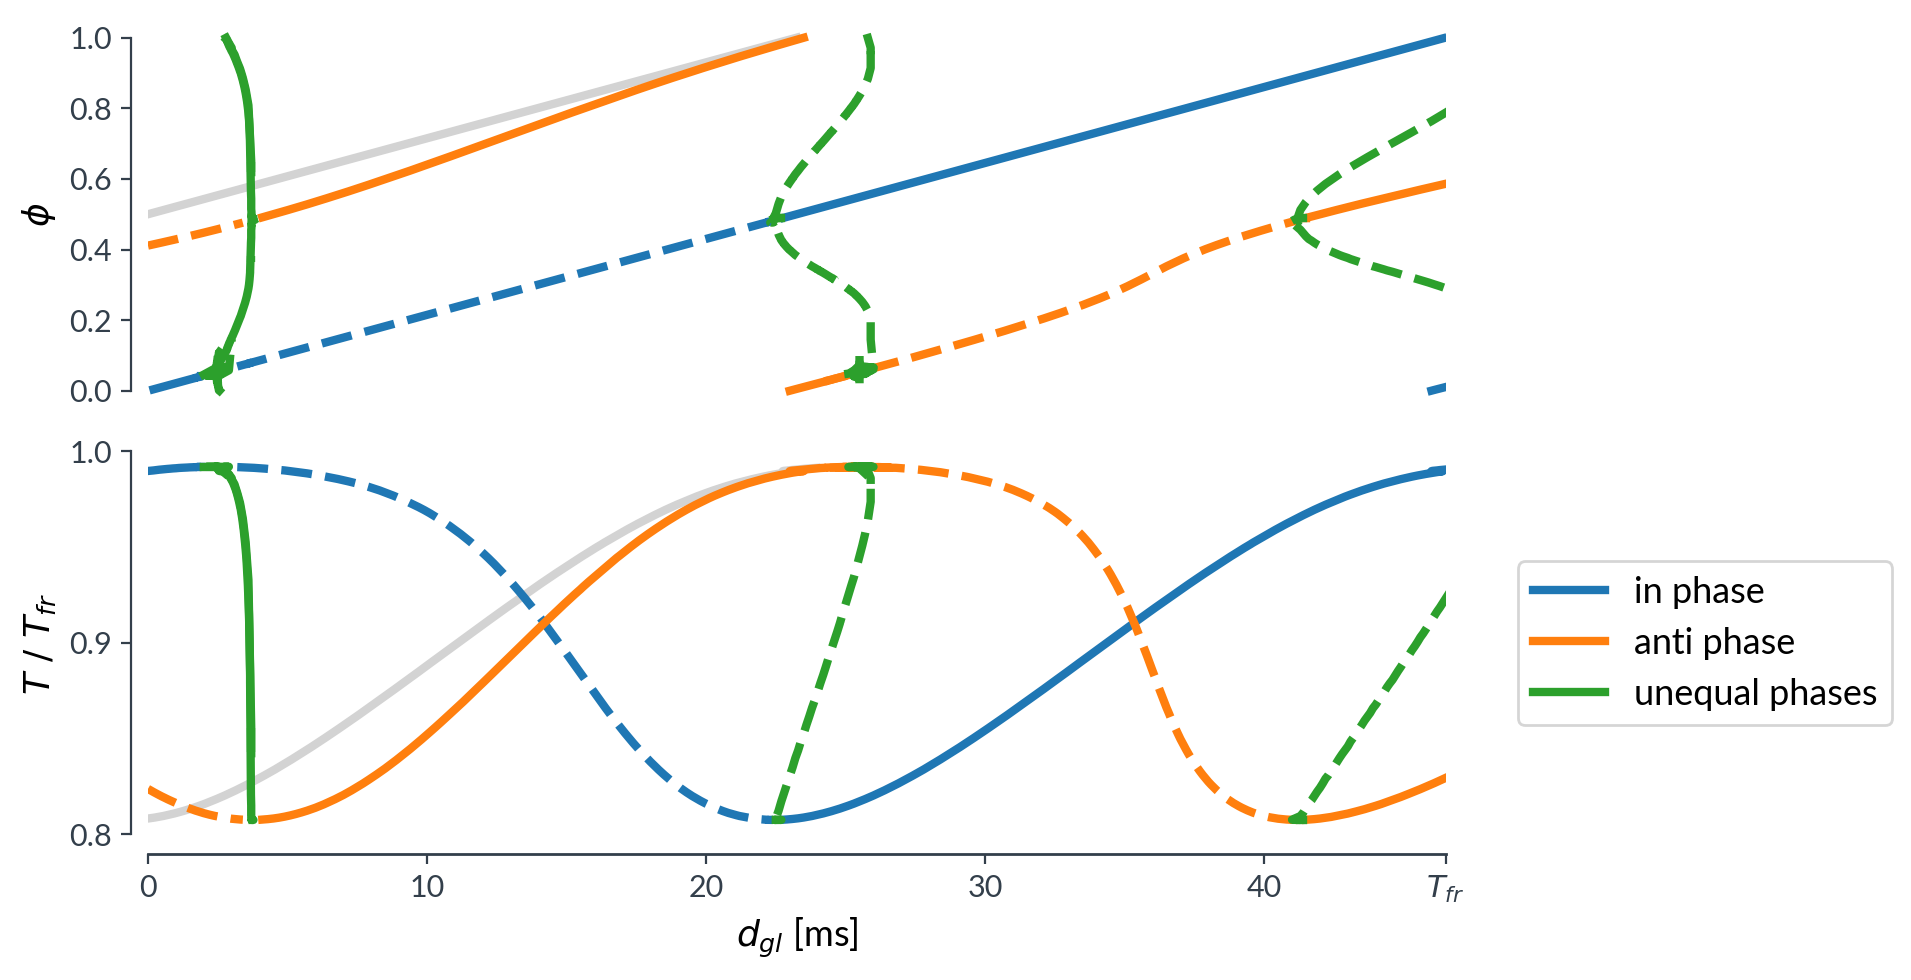

In [15]:
plt.rcParams['font.family'] = 'Lato'
plt.rcParams['font.sans-serif'] = 'Lato'
plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'
plt.rcParams['axes.labelsize']=13
plt.rcParams['xtick.labelsize']=11
plt.rcParams['ytick.labelsize']=11
plt.rcParams['legend.fontsize'] = 13

def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    handles, labels = [*zip(*unique)]
    ax.legend(handles, labels, bbox_to_anchor=(1.2, 0.5), loc="center", ncol=1, fontsize=13)

fig, axs= plt.subplots(2,1, figsize=(10,5), dpi=200, sharex=True)

ax = axs[0] 

branches = find_branches_phases(States['in_u_d'], States['in_u_p'], dis=5)
for br in branches:
    ax.plot(br[0], br[2] / prc.frperiod, "--", c = "tab:blue", lw=3)

branches = find_branches_phases(States['in_s_d'], States['in_s_p'], dis=0.1)
for br in branches:
    cut = 0
    for i in range(len(br[0]) -1 ):
        if br[2][i+1] - br[2][i] > 10:
            cut = i
    ax.plot(br[0][:cut], br[2][:cut]/ prc.frperiod, "-", c="tab:blue", lw=3, label="in phase")
    ax.plot(br[0][cut+1:], br[2][cut+1:]/ prc.frperiod, "-", c="tab:blue",lw=3, label="in phase")
    
branches = find_branches_phases(States['anti_u_d'], States['anti_u_p'])
for br in branches:
    ax.plot(br[0], br[2]/ prc.frperiod, "--", c = "tab:orange", lw=3)

branches = find_branches_phases(States['anti_s_d'], States['anti_s_p'], dis=0.1)
for br in branches:
    cut = 0
    for i in range(len(br[0]) -1 ):
        if br[2][i+1] - br[2][i] > 10:
            cut = i
    ax.plot(br[0][:cut], br[2][:cut]/ prc.frperiod, "-", c="tab:orange", lw=3, label="anti phase")
    ax.plot(br[0][cut+1:], br[2][cut+1:]/ prc.frperiod, "-", c="tab:orange", lw=3, label="anti phase")

    
branches = find_branches_phases(States['oop_u_d'], States['oop_u_p1'])
for br in branches:
    cut = 0
    for i in range(len(br[0]) -1 ):
        if br[2][i+1] - br[2][i] > 10:
            cut = i
    ax.plot(br[0][:cut], br[2][:cut]/ prc.frperiod, "--", c = "tab:green", lw=3)
    ax.plot(br[0][cut+1:], br[2][cut+1:]/ prc.frperiod, "--", c = "tab:green", lw=3)

branches = find_branches_phases(States['oop_u_d'], States['oop_u_p2'])
for br in branches:
    cut = 0
    for i in range(len(br[0]) -1 ):
        if br[2][i+1] - br[2][i] > 10:
            cut = i
    ax.plot(br[0][:cut], br[2][:cut]/ prc.frperiod, "--", c = "tab:green", lw=3)
    ax.plot(br[0][cut+1:], br[2][cut+1:]/ prc.frperiod, "--", c = "tab:green", lw=3)

branches = find_branches_phases(States['oop_s_d'], States['oop_s_p1'])
for br in branches:
    cut = 0
    for i in range(len(br[0]) -1 ):
        if br[2][i+1] - br[2][i] > 10:
            cut = i    
    axs[0].plot(br[0][:cut], br[2][:cut]/prc.frperiod, "-", c="tab:green", lw=3, label="unequal phases")
    axs[0].plot(br[0][cut+1:], br[2][cut+1:]/prc.frperiod, "-", c="tab:green", lw=3, label="unequal phases")

    
branches = find_branches_phases(States3['oop_s_d'], States3['oop_s_p2'])
for br in branches:
    cut = 0
    for i in range(len(br[0]) -1 ):
        if br[2][i+1] - br[2][i] > 10:
            cut = i
    ax.plot(br[0][:cut], br[2][:cut]/ prc.frperiod, "-", c="tab:green", lw=3, label="unequal phases")
    ax.plot(br[0][cut+1:], br[2][cut+1:]/ prc.frperiod, "-", c="tab:green", lw=3, label="unequal phases")

    
branches = find_branches_phases(States3['oop_s_d'], States3['oop_s_p1'])
for br in branches:
    cut = 0
    for i in range(len(br[0]) -1 ):
        if br[2][i+1] - br[2][i] > 10:
            cut = i    
    ax.plot(br[0][:cut], br[2][:cut]/ prc.frperiod, "-", c="tab:green", lw=3, label="unequal phases")
    ax.plot(br[0][cut+1:], br[2][cut+1:]/ prc.frperiod, "-", c="tab:green", lw=3, label="unequal phases")

#ax.text(prc.frperiod/2, 0, r'$k = 1$', size=13)
#ax.text(3*prc.frperiod/2, 0, r'$k = 2$', size=13)
#ax.text(5*prc.frperiod/2, 0, r'$k = 3$', size=13)

#ax.axvline(prc.frperiod, c="grey", lw=2)

#ax.axvline(2*prc.frperiod, c="grey", lw=2)
ax.plot([0, prc.frperiod/2],[1/2, 1], c="lightgrey", lw=3, zorder=1)
#x.plot([prc.frperiod/2, prc.frperiod],[0, 1/2], c="lightgrey", lw=3, zorder=1)

ax.set_ylabel(r"$\phi$")
#ax.set_xlabel(r"$d_{gl}$ [ms]")

ax.set_xlim(0, prc.frperiod)


ax.set_xticks([0, 10, 20, 30, 40, prc.frperiod])
ax.set_xticklabels(labels=['0','10','20','30','40', r'$T_{fr}$'])


#ax.set_yticks([0.8, 0.9, 1])
#ax.set_yticklabels(['0.8', '0.9', '1.0'])

ax.tick_params(right=False, top=False, bottom=False)

ax.spines["top"].set_visible(False), ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)

plt.draw()

lab = [float(item.get_text().replace("−", "-")) for item in ax.get_yticklabels(which='both')][1:-1]
ax.spines["left"].set_bounds(low=min(lab), high=max(lab))
ax.spines["left"].set_position(("outward", 6))

ax.spines["bottom"].set_bounds(low=0, high=prc.frperiod)
ax.spines["bottom"].set_linewidth(1)
ax.spines["bottom"].set_position(("outward",6))

ax = axs[1]

branches = find_branches(States['in_u_d'], States['in_u_p'], dis=5)
for br in branches:
    ax.plot(br[0], (prc.frperiod - br[1])/prc.frperiod, "--", c = "tab:blue", lw=3)
    
branches = find_branches(States['in_s_d'], States['in_s_p'], dis=0.1)
for br in branches:
    ax.plot(br[0], (prc.frperiod - br[1])/prc.frperiod, "-", c="tab:blue", lw=3, label="in phase")
    
branches = find_branches(States['anti_u_d'], States['anti_u_p'])
for br in branches:
    ax.plot(br[0], (prc.frperiod - br[1])/prc.frperiod, "--", c = "tab:orange", lw=3)

branches = find_branches(States['anti_s_d'], States['anti_s_p'], dis=0.1)
for br in branches:   
    ax.plot(br[0], (prc.frperiod - br[1])/prc.frperiod, "-", c="tab:orange", lw=3, label="anti phase")
    

branches = find_branches(States['oop_u_d'], States['oop_u_p2'])
#ic(len(branches))
for br in branches:
    ax.plot(br[0], (prc.frperiod - br[1])/prc.frperiod, "--", c = "tab:green", lw=3)
    
branches = find_branches(States['oop_s_d'], States['oop_s_p2'])
for br in branches:   
    ax.plot(br[0], (prc.frperiod - br[1])/prc.frperiod, "-", c="tab:green", lw=3, label="unequal phases")

branches = find_branches(States3['oop_s_d'], States3['oop_s_p2'])
for br in branches:   
    ax.plot(br[0], (prc.frperiod - br[1])/prc.frperiod, "-", c="tab:green", lw=3, label="unequal phases")

branches = find_branches(States['in_s_d'], States['in_s_p'], dis=0.1)
br = branches[1]
ax.plot(br[0] - prc.frperiod/2, (prc.frperiod - br[1])/prc.frperiod, "-", c="lightgrey", lw=3, label="in phase", zorder=1)

    
ax.tick_params(right=False, top=False)

ax.spines["top"].set_visible(False), ax.spines["right"].set_visible(False)

plt.draw()

lab = [float(item.get_text().replace("−", "-")) for item in ax.get_yticklabels(which='both')][1:-1]
ax.spines["left"].set_bounds(low=min(lab), high=max(lab))
ax.spines["left"].set_position(("outward", 6))

ax.spines["bottom"].set_bounds(low=0, high=prc.frperiod)
ax.spines["bottom"].set_linewidth(1)
ax.spines["bottom"].set_position(("outward",6))

ax.set_yticks([0.8, 0.9, 1])
ax.set_yticklabels(labels=['0.8','0.9','1.0'])

ax.set_ylabel(r"$T \ / \ T_{fr}$")
ax.set_xlabel(r"$d_{gl}$ [ms]")

#axs[0].set_title("Kegl = 50")
legend_without_duplicate_labels(ax)
fig.tight_layout()

#fig.savefig("Pics/Two_Node_Phases_branch_squeezing.pdf")

# both phases and periods together

ic| d_step: 0.10000000000000142
ic| len(branches): 5
ic| d_step: 0.09999999999999432
ic| len(branches): 6
ic| d_step: 0.10000000000000142
ic| len(branches): 4
ic| d_step: 0.09999999999999432
ic| len(branches): 5
ic| d_step: 0.09999999999999432
ic| len(branches): 9
ic| d_step: 0.09999999999999432
ic| len(branches): 9
ic| d_step: 0.10000000000000009
ic| len(branches): 13
ic| d_step: 0.10000000000000009
ic| len(branches): 13
ic| d_step: 0.009999999999999787
ic| len(branches): 1
ic| d_step: 0.009999999999999787
ic| len(branches): 1
ic| len(branches): 5
ic| len(branches): 6
ic| len(branches): 4
ic| len(branches): 5
ic| len(branches): 9
ic| len(branches): 13
ic| len(branches): 9
ic| len(branches): 1


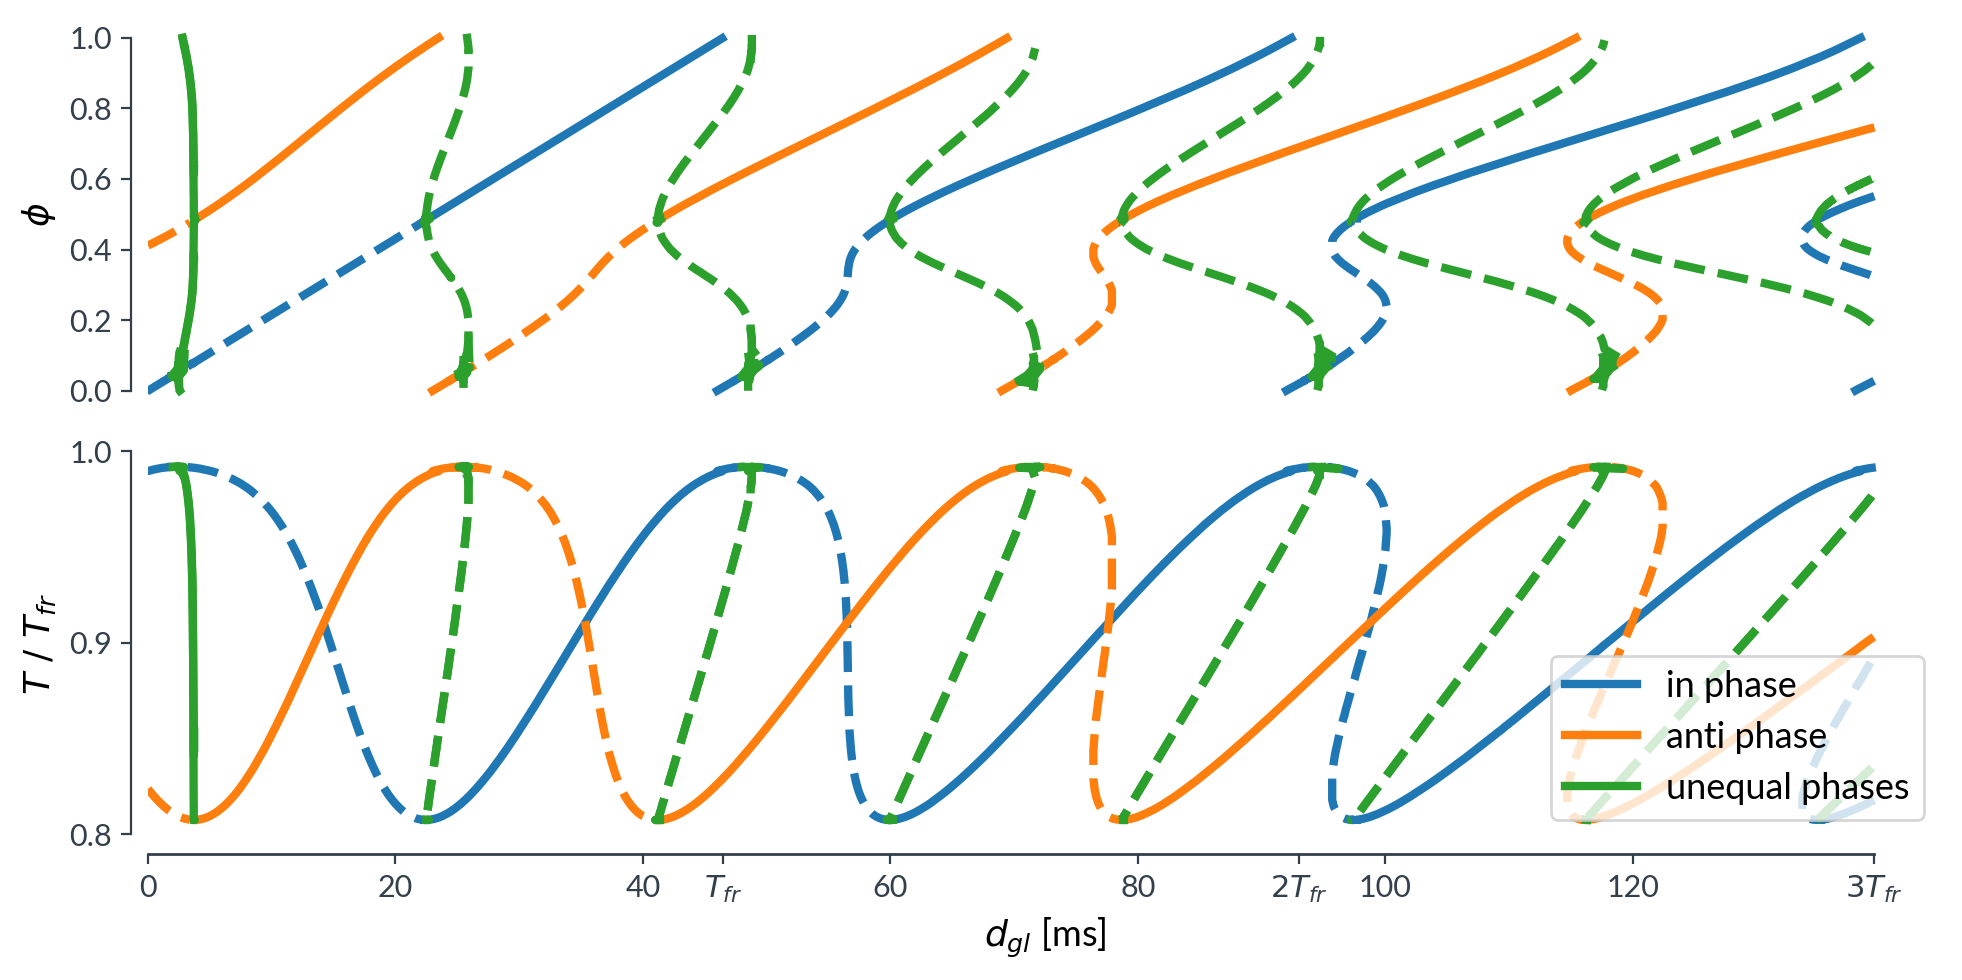

In [16]:
plt.rcParams['font.family'] = 'Lato'
plt.rcParams['font.sans-serif'] = 'Lato'
plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'
plt.rcParams['axes.labelsize']=13
plt.rcParams['xtick.labelsize']=11
plt.rcParams['ytick.labelsize']=11
plt.rcParams['legend.fontsize'] = 13

def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    handles, labels = [*zip(*unique)]
    ax.legend(handles, labels, loc="lower right")

fig, axs = plt.subplots(2,1, figsize=(10, 5), dpi=200, sharex=True)

ax = axs[0]

branches = find_branches_phases(States['in_u_d'], States['in_u_p'], dis=5)
for br in branches:
    axs[0].plot(br[0], br[2]/prc.frperiod, "--", c = "tab:blue", lw=3)

branches = find_branches_phases(States['in_s_d'], States['in_s_p'], dis=0.1)
for br in branches:
    cut = 0
    for i in range(len(br[0]) -1 ):
        if br[2][i+1] - br[2][i] > 10:
            cut = i
    axs[0].plot(br[0][:cut], br[2][:cut]/prc.frperiod, "-", c="tab:blue", lw=3, label="in phase")
    axs[0].plot(br[0][cut+1:], br[2][cut+1:]/prc.frperiod, "-", c="tab:blue",lw=3, label="in phase")
    
branches = find_branches_phases(States['anti_u_d'], States['anti_u_p'])
for br in branches:
    axs[0].plot(br[0], br[2]/prc.frperiod, "--", c = "tab:orange", lw=3)

branches = find_branches_phases(States['anti_s_d'], States['anti_s_p'], dis=0.1)
for br in branches:
    cut = 0
    for i in range(len(br[0]) -1 ):
        if br[2][i+1] - br[2][i] > 10:
            cut = i
    axs[0].plot(br[0][:cut], br[2][:cut]/prc.frperiod, "-", c="tab:orange", lw=3, label="anti phase")
    axs[0].plot(br[0][cut+1:], br[2][cut+1:]/prc.frperiod, "-", c="tab:orange", lw=3, label="anti phase")

    
branches = find_branches_phases(States['oop_u_d'], States['oop_u_p1'])
for br in branches:
    cut = 0
    for i in range(len(br[0]) -1 ):
        if br[2][i+1] - br[2][i] > 10:
            cut = i
    axs[0].plot(br[0][:cut], br[2][:cut]/prc.frperiod, "--", c = "tab:green", lw=3)
    axs[0].plot(br[0][cut+1:], br[2][cut+1:]/prc.frperiod, "--", c = "tab:green", lw=3)

branches = find_branches_phases(States['oop_u_d'], States['oop_u_p2'])
for br in branches:
    cut = 0
    for i in range(len(br[0]) -1 ):
        if br[2][i+1] - br[2][i] > 10:
            cut = i
    axs[0].plot(br[0][:cut], br[2][:cut]/prc.frperiod, "--", c = "tab:green", lw=3)
    axs[0].plot(br[0][cut+1:], br[2][cut+1:]/prc.frperiod, "--", c = "tab:green", lw=3)

branches = find_branches_phases(States['oop_s_d'], States['oop_s_p2'])
for br in branches:
    cut = 0
    for i in range(len(br[0]) -1 ):
        if br[2][i+1] - br[2][i] > 10:
            cut = i
    axs[0].plot(br[0][:cut], br[2][:cut]/prc.frperiod, "-", c="tab:green", lw=3, label="unequal phases")
    axs[0].plot(br[0][cut+1:], br[2][cut+1:]/prc.frperiod, "-", c="tab:green", lw=3, label="unequal phases")

    
branches = find_branches_phases(States['oop_s_d'], States['oop_s_p1'])
for br in branches:
    cut = 0
    for i in range(len(br[0]) -1 ):
        if br[2][i+1] - br[2][i] > 10:
            cut = i    
    axs[0].plot(br[0][:cut], br[2][:cut]/prc.frperiod, "-", c="tab:green", lw=3, label="unequal phases")
    axs[0].plot(br[0][cut+1:], br[2][cut+1:]/prc.frperiod, "-", c="tab:green", lw=3, label="unequal phases")

branches = find_branches_phases(States3['oop_s_d'], States3['oop_s_p2'])
for br in branches:
    cut = 0
    for i in range(len(br[0]) -1 ):
        if br[2][i+1] - br[2][i] > 10:
            cut = i
    ax.plot(br[0][:cut], br[2][:cut]/ prc.frperiod, "-", c="tab:green", lw=3, label="unequal phases")
    ax.plot(br[0][cut+1:], br[2][cut+1:]/ prc.frperiod, "-", c="tab:green", lw=3, label="unequal phases")

    
branches = find_branches_phases(States3['oop_s_d'], States3['oop_s_p1'])
for br in branches:
    cut = 0
    for i in range(len(br[0]) -1 ):
        if br[2][i+1] - br[2][i] > 10:
            cut = i    
    ax.plot(br[0][:cut], br[2][:cut]/ prc.frperiod, "-", c="tab:green", lw=3, label="unequal phases")
    ax.plot(br[0][cut+1:], br[2][cut+1:]/ prc.frperiod, "-", c="tab:green", lw=3, label="unequal phases")

#ax.text(prc.frperiod/2, 0, r'$k = 1$', size=13)
#ax.text(3*prc.frperiod/2, 0, r'$k = 2$', size=13)
#ax.text(5*prc.frperiod/2, 0, r'$k = 3$', size=13)

#ax.axvline(prc.frperiod, c="grey", lw=2)

#ax.axvline(2*prc.frperiod, c="grey", lw=2)



ax.set_ylabel(r"$\phi$")


ax.tick_params(right=False, top=False, bottom=False)

ax.spines["top"].set_visible(False), ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)

plt.draw()

lab = [float(item.get_text().replace("−", "-")) for item in ax.get_yticklabels(which='both')[1:-1]]
ax.spines["left"].set_bounds(low=min(lab), high=max(lab))
ax.spines["left"].set_position(("outward", 6))


ax = axs[1]

branches = find_branches(States['in_u_d'], States['in_u_p'], dis=5)
for br in branches:
    ax.plot(br[0], (prc.frperiod - br[1])/prc.frperiod, "--", c = "tab:blue", lw=3)
    
branches = find_branches(States['in_s_d'], States['in_s_p'], dis=0.1)
for br in branches:
    ax.plot(br[0], (prc.frperiod - br[1])/prc.frperiod, "-", c="tab:blue", lw=3, label="in phase")
    
branches = find_branches(States['anti_u_d'], States['anti_u_p'])
for br in branches:
    ax.plot(br[0], (prc.frperiod - br[1])/prc.frperiod, "--", c = "tab:orange", lw=3)

branches = find_branches(States['anti_s_d'], States['anti_s_p'], dis=0.1)
for br in branches:   
    ax.plot(br[0], (prc.frperiod - br[1])/prc.frperiod, "-", c="tab:orange", lw=3, label="anti phase")
    
    
branches = find_branches(States['oop_u_d'], States['oop_u_p1'])
#ic(len(branches))
for br in branches:
    ax.plot(br[0], (prc.frperiod - br[1])/prc.frperiod, "--", c = "tab:green", lw=3)


branches = find_branches(States['oop_s_d'], States['oop_s_p2'])
for br in branches:   
    ax.plot(br[0], (prc.frperiod - br[1])/prc.frperiod, "-", c="tab:green", lw=3, label="unequal phases")
    
    
branches = find_branches(States['oop_u_d'], States['oop_u_p1'])
#ic(len(branches))
for br in branches:
    ax.plot(br[0], (prc.frperiod - br[1])/prc.frperiod, "--", c = "tab:green", lw=3)


branches = find_branches(States3['oop_s_d'], States3['oop_s_p2'])
for br in branches:   
    ax.plot(br[0], (prc.frperiod - br[1])/prc.frperiod, "-", c="tab:green", lw=3, label="unequal phases")
    
#ax.text(prc.frperiod/2, 0, r'$k = 1$', size=13)
#ax.text(3*prc.frperiod/2, 0, r'$k = 2$', size=13)
#ax.text(5*prc.frperiod/2, 0, r'$k = 3$', size=13)

#ax.axvline(prc.frperiod, c="grey", lw=2)

#ax.axvline(2*prc.frperiod, c="grey", lw=2)



ax.set_ylabel(r"$T \ / \ T_{fr}$")
ax.set_xlabel(r"$d_{gl}$ [ms]")

ax.set_xlim(0, 145)


ax.set_xticks([0, 20, 40, 60, 80, 100, 120, prc.frperiod, 2*prc.frperiod, 3*prc.frperiod])
ax.set_xticklabels(labels=['0','20','40','60','80','100','120', r'$T_{fr}$', r'$2T_{fr}$', r'$3T_{fr}$'])


ax.set_yticks([0.8, 0.9, 1])
ax.set_yticklabels(['0.8', '0.9', '1.0'])

ax.tick_params(right=False, top=False)

ax.spines["top"].set_visible(False), ax.spines["right"].set_visible(False)

plt.draw()

lab = [float(item.get_text().replace("−", "-")) for item in ax.get_yticklabels(which='both')]
ax.spines["left"].set_bounds(low=min(lab), high=max(lab))
ax.spines["left"].set_position(("outward", 6))

ax.spines["bottom"].set_bounds(low=0, high=3*prc.frperiod)
ax.spines["bottom"].set_linewidth(1)
ax.spines["bottom"].set_position(("outward",6))



#axs[0].set_title("Kegl = 50")
legend_without_duplicate_labels(ax)
fig.tight_layout()
#fig.savefig("Pics/Two_Node_Phases_Periods_all_3.pdf")

## Simulations

In [17]:
def get_all_stim_freqs(delay):
    ''' System Frequency is function of delay can be approximated in two ways
    1. (synchroinzation_state + 1) x Period + 50 = 2 x delay 
    2. synchroniation_state x Period = 2 * delay 
    The second is a little worse but fits better to my theory.'''
    def method_one(state, sys_delay):
        period = (sys_delay+50) / (state+1)  
        return 1000 / period
    
    def method_two(state, sys_delay):
        if state == 0:
            period = sys_delay / (state+1)
        else:
            period = sys_delay / state
        period += 1
        return 1000 / period 

    ret = []
    for i in range(7):
        if i % 2 == 0:
            ret.append(('in', method_one(state = i, sys_delay= 2 * delay)))
        else:
            ret.append(('anti', method_one(state = i, sys_delay= 2 * delay)))
    
    return ret

In [18]:
SP_WINDOW = 100

def evalf(traj):
    pars = search.getParametersFromTraj(traj)

    aln.params['signalV'] = pars['signalV']
    
    # calc absolute interareal delay
    delay = aln.params.lengthMat[0,1] / aln.params.signalV
    
    sfreqs = get_all_stim_freqs(delay)
    freqs = np.ndarray((len(sfreqs)))
    shifts = np.ndarray((len(sfreqs)))
    
    for i, sfreq in enumerate(sfreqs):
        stim_type = sfreq[0]
        stim_freq = sfreq[1]
        
        if stim_type == 'anti':
            stimulus = construct_antiphase_stimulus(stim_bias = 0, 
                                       duration = aln.params.duration, 
                                       dt = aln.params.dt, 
                                       stim_freq_anti = int(stim_freq), 
                                       n_periods_anti = int(2*stim_freq),
                                       stim_amp = 0.4, 
                                       nostim_before = 0,
                                       nostim_after = aln.params.duration,
                                       decay=True)
        elif stim_type == 'in':
            stimulus = construct_inphase_stimulus(stim_bias = 0, 
                                       duration = aln.params.duration, 
                                       dt = aln.params.dt, 
                                       stim_freq_in = int(stim_freq), 
                                       n_periods_in = int(2*stim_freq),
                                       stim_amp = 0.4, 
                                       nostim_before = 0,
                                       nostim_after = aln.params.duration,
                                       decay=True)
        else:
            print("Stim type not defined:")
            results_dict = {}
            search.saveOutputsToPypet(result_dict, traj)
            return
        
        aln.params['ext_exc_current'] = stimulus
        aln.randomICs()
        aln.run()
        
        # Evaluation
        stage = aln['rates_exc'][:, int(5000/aln.params.dt) :]
        stim_shift = phase_shift(stage[0], stage[1], duration=10000, dt=aln.params.dt)
        domfreq = dom_frequency(stage[0],
                            dt=aln.params['dt'],
                            SP_WINDOW=SP_WINDOW)
        
        shifts[i] = stim_shift[0] # stim_shift in [0,1]
        freqs[i] = domfreq
        
        
        
    result_dict = {"delay" : delay, 
                   #"sfreq" : sfreqs[1],
                   "shifts" : shifts,
                   "frequencies" : freqs}   
        
    search.saveToPypet(result_dict, traj)
    return

In [19]:
Cmat = np.ones((2,2))
np.fill_diagonal(Cmat, 0)
Dmat = Cmat.copy()
Dmat *= 50 

aln = ALNModel(Cmat = Cmat, Dmat = Dmat)
# Put ALN in "A3" Point right inside the LC_EI
aln.params['mue_ext_mean'] = 1.1
aln.params['mui_ext_mean'] = 0.5

# no adaptation 
aln.params['a'] = 0.
aln.params['b'] = 0. 

aln.params['sigma_ou'] = 0.

# coupling strength
aln.params['Ke_gl'] = 50.

aln.params['dt'] = 0.005

aln.params['duration'] = 30 * 1000 

INFO:root:aln: Model initialized.


In [20]:
def delayToVelocity(delay, distance=50):
    '''delay in my, distance in mm'''
    return distance / delay

delay = np.arange(0, 140, 0.5)
#delay = np.arange(0, 100, 200)

signalV = delayToVelocity(delay)

parameters = ParameterSpace({"signalV": signalV})
#parameters = ParameterSpace({"signalV": [1],
#                             "Ke_gl": [100]})
search = BoxSearch(evalFunction = evalf,
                   parameterSpace=parameters,
                   filename=HDF_PATH+'Clean_TwoNode_compare_PRC_prediction_sync_modes_Ke=50.hdf',
                   ncores=6)

INFO:root:Number of processes: 6
MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `./data/hdf/../../../../Data/Clean_TwoNode_compare_PRC_prediction_sync_modes_Ke=50.hdf`.
MainProcess pypet.environment.Environment INFO     Environment initialized.
MainProcess root INFO     Number of parameter configurations: 280
MainProcess root INFO     BoxSearch: Environment initialized.


In [21]:
#search.run()

In [22]:
search.loadResults()

MainProcess root INFO     Loading results from ./data/hdf/../../../../Data/Clean_TwoNode_compare_PRC_prediction_sync_modes_Ke=50.hdf
MainProcess root INFO     Analyzing trajectory results-2021-11-04-18H-40M-13S
MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `./data/hdf/../../../../Data/Clean_TwoNode_compare_PRC_prediction_sync_modes_Ke=50.hdf`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading trajectory `results-2021-11-04-18H-40M-13S`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `config` in mode `2`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `parameters` in mode `2`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `results` in mode `1`.
MainProcess root INFO     Creating `dfResults` dataframe ...
MainProcess root INFO     Loading all results to `results` dictionary ...
100%|██████████| 280/280 [00:01<00:00, 156.11it/s]
MainProcess roo

In [23]:
df = search.dfResults

ic| handles: (<matplotlib.collections.PathCollection object at 0x7efc243f5dd8>,
              <matplotlib.collections.PathCollection object at 0x7efc48da9c18>)
    labels: ('in-phase', 'anti-phase', 'out of phase')


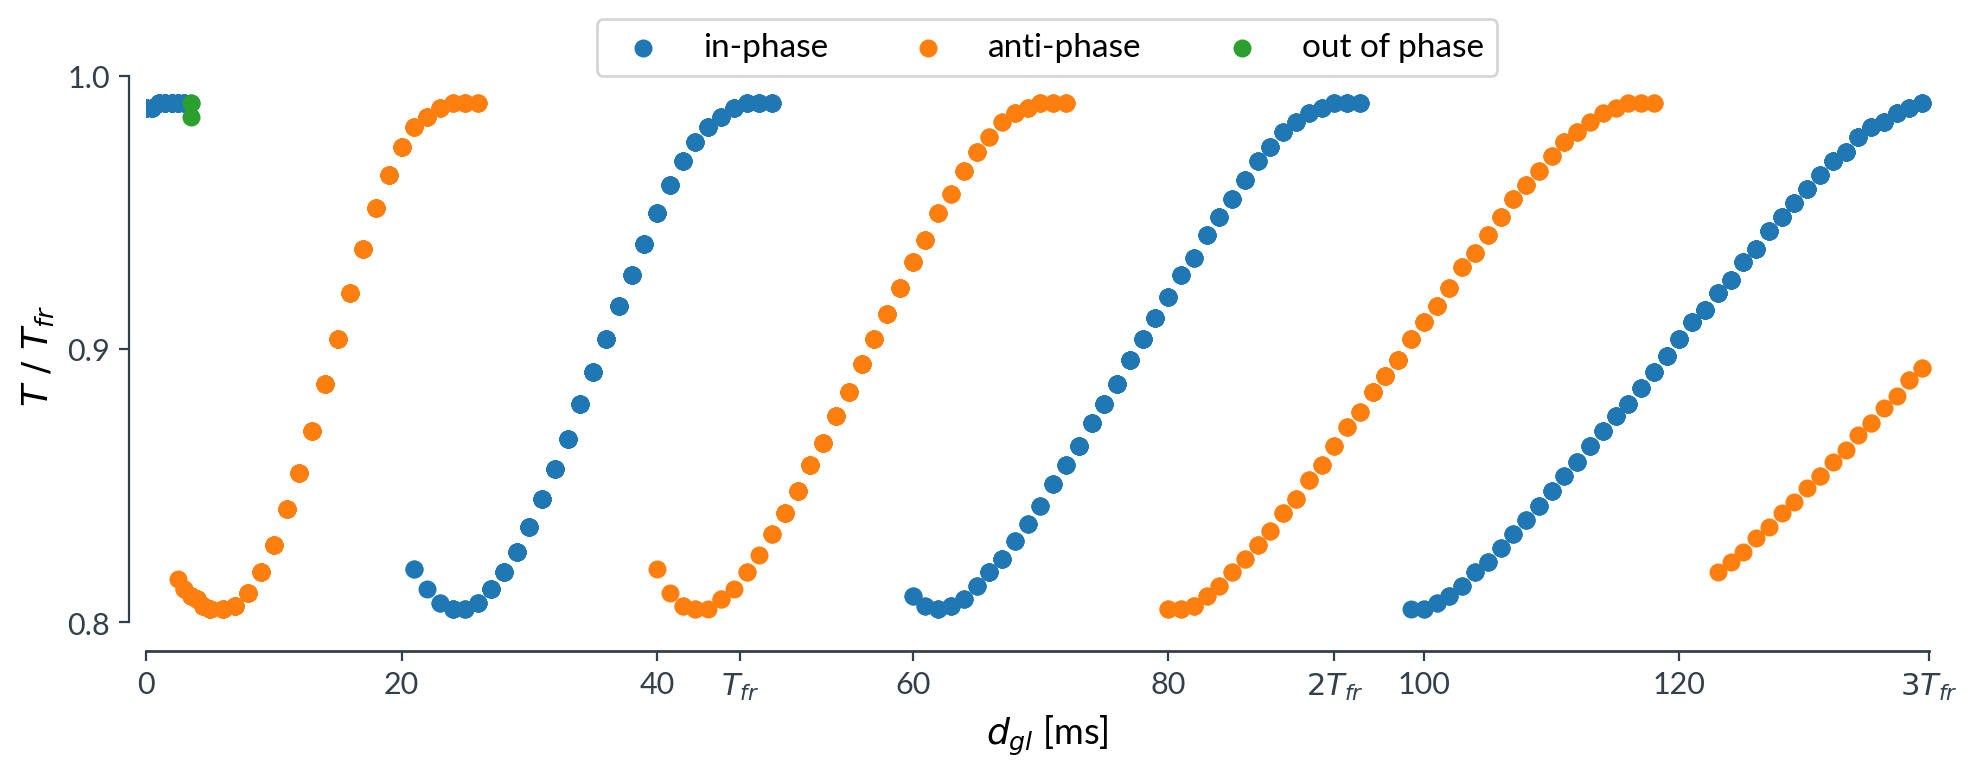

In [24]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Lato'
plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'
plt.rcParams['axes.labelsize']=13
plt.rcParams['xtick.labelsize']=11
plt.rcParams['ytick.labelsize']=11
plt.rcParams['legend.fontsize'] = 13

from matplotlib.lines import Line2D

def legend_without_duplicate_labels(ax):
    circ1 = Line2D([0], [0], linestyle="none", marker="o", color="black", markersize=7, markerfacecolor="black")
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    handles, labels = [*zip(*unique)]
    ic(handles, labels)
    #handles2 = handles[:3] + (circ1, circ1)[:-1]
    #labels2 = labels[:3] + ("simulated", "sim")[:-1]
    #ic(type(labels))
    #ic(handles2, labels2)
    ax.legend(handles, labels, bbox_to_anchor=(0.5, 1.05), loc="center", ncol=4, fontsize=12)
    
fig, ax = plt.subplots(1,1, figsize=(10, 4), dpi=200, sharex=True)


    
#ax.text(prc.frperiod/2, 0, r'$k = 1$', size=13)
#ax.text(3*prc.frperiod/2, 0, r'$k = 2$', size=13)
#ax.text(5*prc.frperiod/2, 0, r'$k = 3$', size=13)

#ax.axvline(prc.frperiod, c="grey", lw=2)

#ax.axvline(2*prc.frperiod, c="grey", lw=2)

#fig, ax = plt.subplots()
#df = search.dfResults
for i in df.index:
    #if df.delay[i] % 1 == 0:
    if (i>10)&(i%2 != 0):
        continue
    for j in range(7):
        if np.isclose(np.abs(df.shifts[i][j]), 1, atol=0.01): 
            ax.scatter(df.delay[i] , 
                       1000/df.frequencies[i][j] /prc.frperiod, 
                       marker="o",
                       c="tab:orange", 
                       label="anti-phase", 
                       s=30,
                       zorder = 5)
        elif np.isclose(np.abs(df.shifts[i][j]), 0, atol=0.01):
            ax.scatter(df.delay[i], 
                       1000/df.frequencies[i][j] /prc.frperiod, 
                       marker="o",
                       c="tab:blue", 
                       label="in-phase", 
                       s=30,
                       zorder = 5)
        else:
            ax.scatter(df.delay[i] , 
                       1000/df.frequencies[i][j] /prc.frperiod, 
                       marker="o",
                       c="tab:green", 
                       label="out of phase", 
                       s=30,
                       zorder=5)
            
ax.set_xlabel("d [ms]")
ax.set_ylabel("T [ms]")
#ax.set_title("Predicted States of Two-Node ALN Kegl=50", y = 1.25)

ax.set_ylabel(r"$T \ / \ T_{fr}$")
ax.set_xlabel(r"$d_{gl}$ [ms]")

ax.set_xlim(0, 141)


#ax.set_xticks([0, 20, 40, 60, 80, 100, 120, prc.frperiod, 2*prc.frperiod, 3*prc.frperiod])
#ax.set_xticklabels(labels=['0','20','40','60','80','100','120', r'$T_{fr}$', r'$2T_{fr}$', r'$3T_{fr}$'])


ax.set_yticks([0.8, 0.9, 1])
ax.set_yticklabels(['0.8', '0.9', '1.0'])

ax.tick_params(right=False, top=False)

ax.spines["top"].set_visible(False), ax.spines["right"].set_visible(False)

plt.draw()

lab = [float(item.get_text().replace("−", "-")) for item in ax.get_yticklabels(which='both')]
ax.spines["left"].set_bounds(low=min(lab), high=max(lab))
ax.spines["left"].set_position(("outward", 6))

ax.spines["bottom"].set_bounds(low=0, high=3*prc.frperiod)
ax.spines["bottom"].set_linewidth(1)
ax.spines["bottom"].set_position(("outward",6))


ax.set_xticks([0, 20, 40, 60, 80, 100, 120, prc.frperiod, 2*prc.frperiod, 3*prc.frperiod])
ax.set_xticklabels(labels=['0','20','40','60','80','100','120', r'$T_{fr}$', r'$2T_{fr}$', r'$3T_{fr}$'])
#axs[0].set_title("Kegl = 50")
legend_without_duplicate_labels(ax)
fig.tight_layout()
#fig.savefig("Pics/Two_Node_Periods_simulation_only.pdf")

ic| handles: (<matplotlib.collections.PathCollection object at 0x7efc4818a208>,
              <matplotlib.collections.PathCollection object at 0x7efc48308978>)
    labels: ('in-phase', 'anti-phase', 'out of phase')


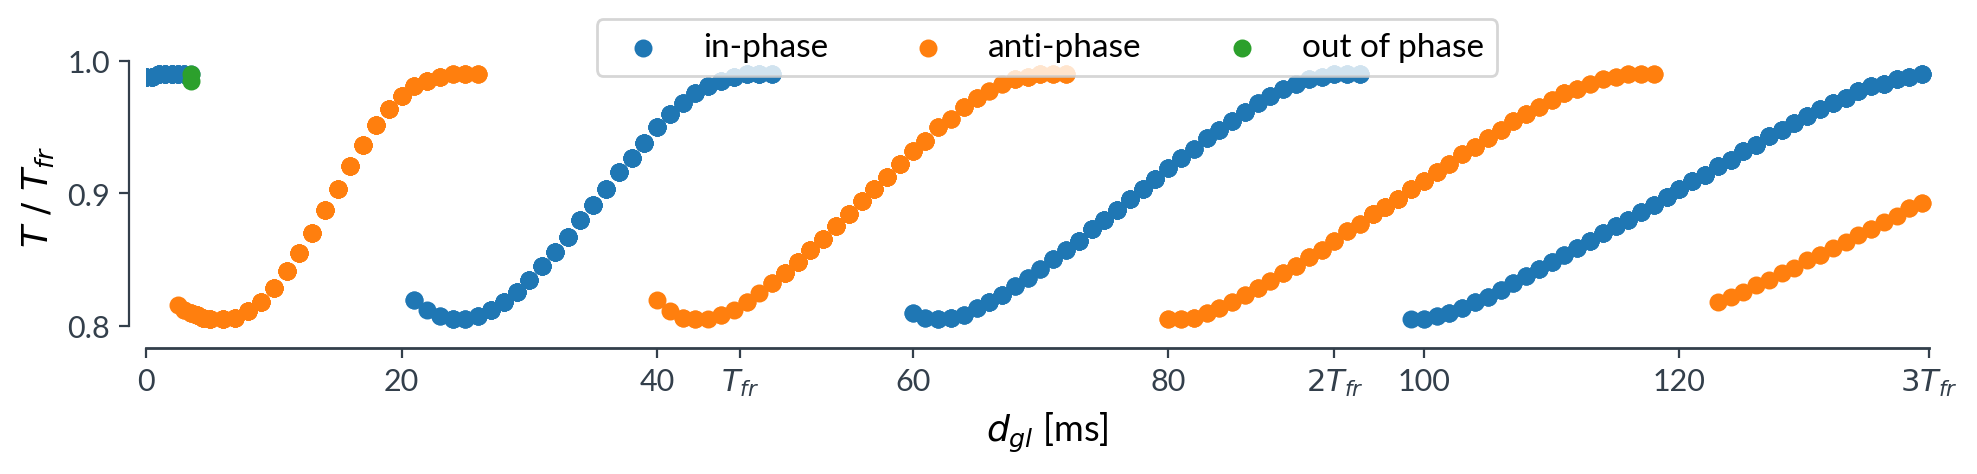

In [25]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Lato'
plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'
plt.rcParams['axes.labelsize']=13
plt.rcParams['xtick.labelsize']=11
plt.rcParams['ytick.labelsize']=11
plt.rcParams['legend.fontsize'] = 13

from matplotlib.lines import Line2D

def legend_without_duplicate_labels(ax):
    circ1 = Line2D([0], [0], linestyle="none", marker="o", color="black", markersize=7, markerfacecolor="black")
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    handles, labels = [*zip(*unique)]
    ic(handles, labels)
    #handles2 = handles[:3] + (circ1, circ1)[:-1]
    #labels2 = labels[:3] + ("simulated", "sim")[:-1]
    #ic(type(labels))
    #ic(handles2, labels2)
    ax.legend(handles, labels, bbox_to_anchor=(0.5, 1.05), loc="center", ncol=4, fontsize=12)
    
fig, ax = plt.subplots(1,1, figsize=(10, 2.5), dpi=200, sharex=True)


    
#ax.text(prc.frperiod/2, 0, r'$k = 1$', size=13)
#ax.text(3*prc.frperiod/2, 0, r'$k = 2$', size=13)
#ax.text(5*prc.frperiod/2, 0, r'$k = 3$', size=13)

#ax.axvline(prc.frperiod, c="grey", lw=2)

#ax.axvline(2*prc.frperiod, c="grey", lw=2)

#fig, ax = plt.subplots()
#df = search.dfResults
for i in df.index:
    #if df.delay[i] % 1 == 0:
    if (i>10)&(i%2 != 0):
        continue
    for j in range(7):
        if np.isclose(np.abs(df.shifts[i][j]), 1, atol=0.01): 
            ax.scatter(df.delay[i] , 
                       1000/df.frequencies[i][j] /prc.frperiod, 
                       marker="o",
                       c="tab:orange", 
                       label="anti-phase", 
                       s=30,
                       zorder = 5)
        elif np.isclose(np.abs(df.shifts[i][j]), 0, atol=0.01):
            ax.scatter(df.delay[i], 
                       1000/df.frequencies[i][j] /prc.frperiod, 
                       marker="o",
                       c="tab:blue", 
                       label="in-phase", 
                       s=30,
                       zorder = 5)
        else:
            ax.scatter(df.delay[i] , 
                       1000/df.frequencies[i][j] /prc.frperiod, 
                       marker="o",
                       c="tab:green", 
                       label="out of phase", 
                       s=30,
                       zorder=5)
            
ax.set_xlabel("d [ms]")
ax.set_ylabel("T [ms]")
#ax.set_title("Predicted States of Two-Node ALN Kegl=50", y = 1.25)

ax.set_ylabel(r"$T \ / \ T_{fr}$")
ax.set_xlabel(r"$d_{gl}$ [ms]")

ax.set_xlim(0, 141)


#ax.set_xticks([0, 20, 40, 60, 80, 100, 120, prc.frperiod, 2*prc.frperiod, 3*prc.frperiod])
#ax.set_xticklabels(labels=['0','20','40','60','80','100','120', r'$T_{fr}$', r'$2T_{fr}$', r'$3T_{fr}$'])


ax.set_yticks([0.8, 0.9, 1])
ax.set_yticklabels(['0.8', '0.9', '1.0'])

ax.tick_params(right=False, top=False)

ax.spines["top"].set_visible(False), ax.spines["right"].set_visible(False)

plt.draw()

lab = [float(item.get_text().replace("−", "-")) for item in ax.get_yticklabels(which='both')]
ax.spines["left"].set_bounds(low=min(lab), high=max(lab))
ax.spines["left"].set_position(("outward", 6))

ax.spines["bottom"].set_bounds(low=0, high=3*prc.frperiod)
ax.spines["bottom"].set_linewidth(1)
ax.spines["bottom"].set_position(("outward",6))


ax.set_xticks([0, 20, 40, 60, 80, 100, 120, prc.frperiod, 2*prc.frperiod, 3*prc.frperiod])
ax.set_xticklabels(labels=['0','20','40','60','80','100','120', r'$T_{fr}$', r'$2T_{fr}$', r'$3T_{fr}$'])
#axs[0].set_title("Kegl = 50")
legend_without_duplicate_labels(ax)
fig.tight_layout()
#fig.savefig("Pics/Two_Node_Periods_simulation_only.pdf")

# Plot both together

ic| len(branches): 5
ic| len(branches): 6
ic| len(branches): 4
ic| len(branches): 5
ic| len(branches): 9
ic| len(branches): 13
ic| len(branches): 1


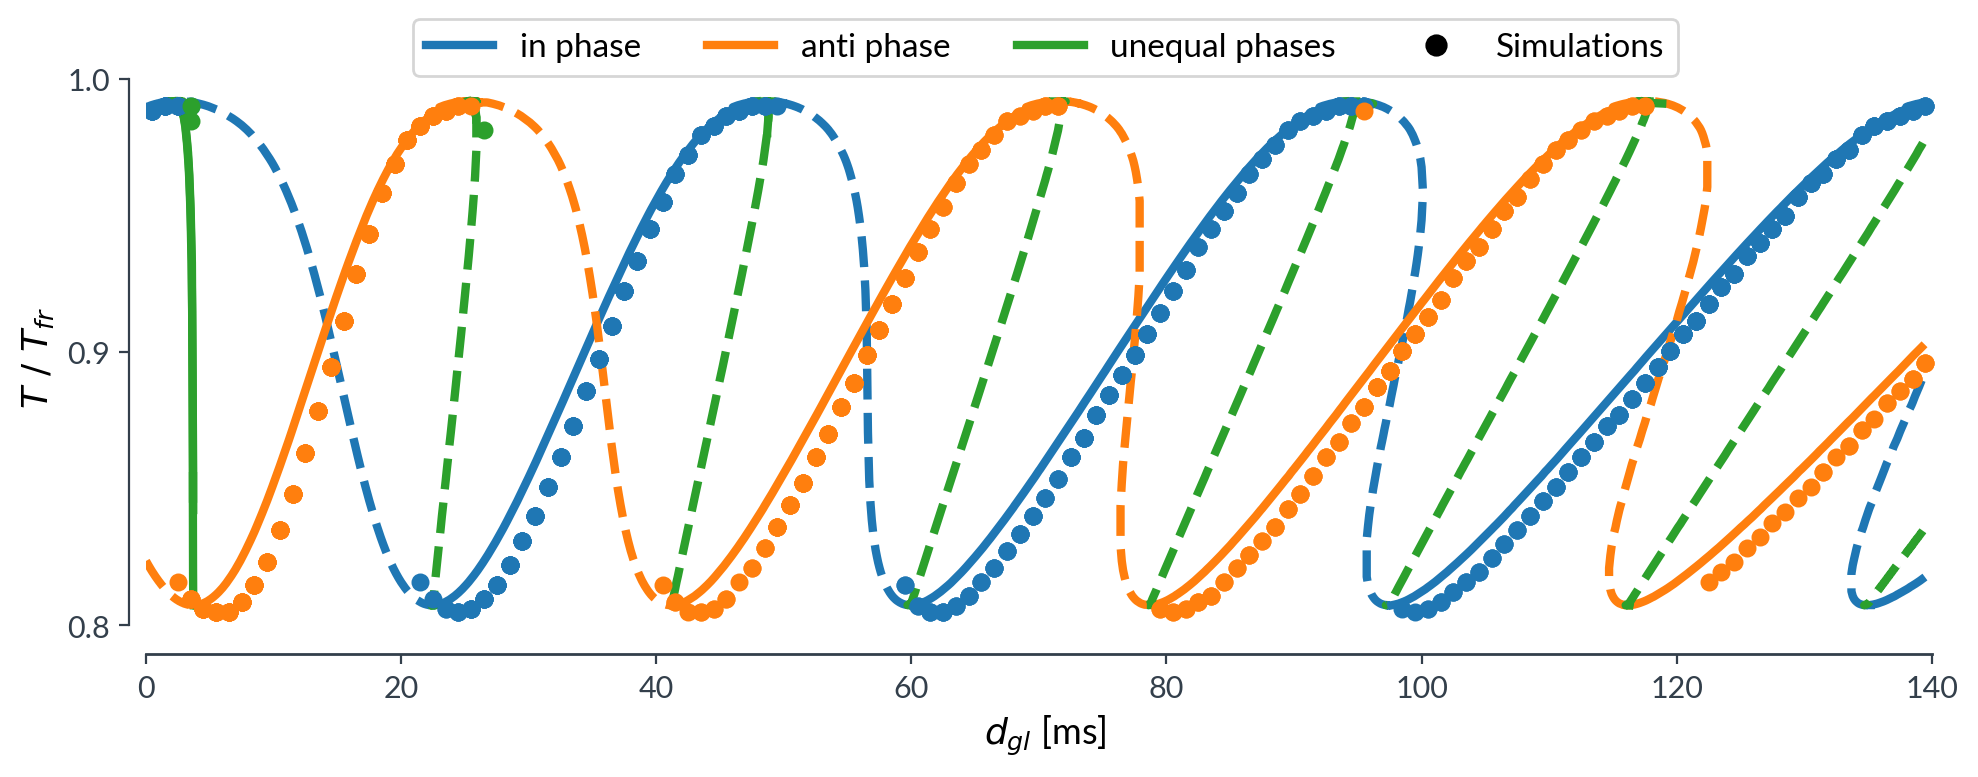

In [26]:
plt.rcParams['font.family'] = 'Lato'
plt.rcParams['font.sans-serif'] = 'Lato'
plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'
plt.rcParams['axes.labelsize']=13
plt.rcParams['xtick.labelsize']=11
plt.rcParams['ytick.labelsize']=11
plt.rcParams['legend.fontsize'] = 13

from matplotlib.lines import Line2D

def legend_without_duplicate_labels(ax):
    circ1 = Line2D([0], [0], linestyle="none", marker="o", color="black", markersize=7, markerfacecolor="black")
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    handles, labels = [*zip(*unique)]
    #ic(handles, labels)
    handles2 = handles[:3] + (circ1, circ1)[:-1]
    labels2 = labels[:3] + ("Simulations", "sim")[:-1]
    #ic(type(labels))
    #ic(handles2, labels2)
    ax.legend(handles2, labels2, bbox_to_anchor=(0.5, 1.05), loc="center", ncol=4, fontsize=12)
    
fig, ax = plt.subplots(1,1, figsize=(10, 4), dpi=200, sharex=True)

branches = find_branches(States['in_u_d'], States['in_u_p'], dis=5)
for br in branches:
    ax.plot(br[0], (prc.frperiod - br[1])/prc.frperiod, "--", c = "tab:blue", lw=3)
    
branches = find_branches(States['in_s_d'], States['in_s_p'], dis=0.1)
for br in branches:
    ax.plot(br[0], (prc.frperiod - br[1])/prc.frperiod, "-", c="tab:blue", lw=3, label="in phase")
    
branches = find_branches(States['anti_u_d'], States['anti_u_p'])
for br in branches:
    ax.plot(br[0], (prc.frperiod - br[1])/prc.frperiod, "--", c = "tab:orange", lw=3)

branches = find_branches(States['anti_s_d'], States['anti_s_p'], dis=0.1)
for br in branches:   
    ax.plot(br[0], (prc.frperiod - br[1])/prc.frperiod, "-", c="tab:orange", lw=3, label="anti phase")
    
    
branches = find_branches(States['oop_u_d'], States['oop_u_p1'])
#ic(len(branches))
for br in branches:
    ax.plot(br[0], (prc.frperiod - br[1])/prc.frperiod, "--", c = "tab:green", lw=3)


branches = find_branches(States['oop_s_d'], States['oop_s_p2'])
for br in branches:   
    ax.plot(br[0], (prc.frperiod - br[1])/prc.frperiod, "-", c="tab:green", lw=3, label="unequal phases")
    
branches = find_branches(States3['oop_s_d'], States3['oop_s_p2'])
for br in branches:   
    ax.plot(br[0], (prc.frperiod - br[1])/prc.frperiod, "-", c="tab:green", lw=3, label="unequal phases")
#ax.text(prc.frperiod/2, 0, r'$k = 1$', size=13)
#ax.text(3*prc.frperiod/2, 0, r'$k = 2$', size=13)
#ax.text(5*prc.frperiod/2, 0, r'$k = 3$', size=13)

#ax.axvline(prc.frperiod, c="grey", lw=2)

#ax.axvline(2*prc.frperiod, c="grey", lw=2)

#fig, ax = plt.subplots()
#df = search.dfResults
for i in df.index:
    #if df.delay[i] % 1 == 0:
    if (i%2 == 0):
        continue
    for j in range(7):
        if np.isclose(np.abs(df.shifts[i][j]), 1, atol=0.01): 
            ax.scatter(df.delay[i] , 
                       1000/df.frequencies[i][j] /prc.frperiod, 
                       marker="o",
                       c="tab:orange", 
                       label="simulated anti-phase", 
                       s=30,
                       zorder = 5)
        elif np.isclose(np.abs(df.shifts[i][j]), 0, atol=0.01):
            ax.scatter(df.delay[i], 
                       1000/df.frequencies[i][j] /prc.frperiod, 
                       marker="o",
                       c="tab:blue", 
                       label="simulated in-phase", 
                       s=30,
                       zorder = 5)
        else:
            ax.scatter(df.delay[i] , 
                       1000/df.frequencies[i][j] /prc.frperiod, 
                       marker="o",
                       c="tab:green", 
                       label="simulated out of phase", 
                       s=30,
                       zorder=5)
            
ax.set_xlabel("d [ms]")
ax.set_ylabel("T [ms]")
#ax.set_title("Predicted States of Two-Node ALN Kegl=50", y = 1.25)

ax.set_ylabel(r"$T \ / \ T_{fr}$")
ax.set_xlabel(r"$d_{gl}$ [ms]")

ax.set_xlim(0, 141)


#ax.set_xticks([0, 20, 40, 60, 80, 100, 120, prc.frperiod, 2*prc.frperiod, 3*prc.frperiod])
#ax.set_xticklabels(labels=['0','20','40','60','80','100','120', r'$T_{fr}$', r'$2T_{fr}$', r'$3T_{fr}$'])


ax.set_yticks([0.8, 0.9, 1])
ax.set_yticklabels(['0.8', '0.9', '1.0'])

ax.tick_params(right=False, top=False)

ax.spines["top"].set_visible(False), ax.spines["right"].set_visible(False)

plt.draw()

lab = [float(item.get_text().replace("−", "-")) for item in ax.get_yticklabels(which='both')]
ax.spines["left"].set_bounds(low=min(lab), high=max(lab))
ax.spines["left"].set_position(("outward", 6))

ax.spines["bottom"].set_bounds(low=0, high=140)
ax.spines["bottom"].set_linewidth(1)
ax.spines["bottom"].set_position(("outward",6))



#axs[0].set_title("Kegl = 50")
legend_without_duplicate_labels(ax)
fig.tight_layout()
#fig.savefig("Pics/Two_Node_Periods_simulation_and_prediction_2.pdf")

In [2]:
# from neurolib.utils.functions
def construct_stimulus(
    stim="dc",
    duration=6000,
    dt=0.1,
    stim_amp=0.2,
    stim_freq=1,
    stim_bias=0,
    n_periods=None,
    nostim_before=0,
    nostim_after=0,
):
    """Constructs a stimulus that can be applied to a model

    :param stim: Stimulation type: 'ac':oscillatory stimulus, 'dc': stimple step current, 
                'rect': step current in negative then positive direction with slowly
                decaying amplitude, used for bistability detection, defaults to 'dc'
    :type stim: str, optional
    :param duration: Duration of stimulus in ms, defaults to 6000
    :type duration: int, optional
    :param dt: Integration time step in ms, defaults to 0.1
    :type dt: float, optional
    :param stim_amp: Amplitude of stimulus (for AdEx: in mV/ms, multiply by conductance C to get current in pA), defaults to 0.2
    :type stim_amp: float, optional
    :param stim_freq: Stimulation frequency, defaults to 1
    :type stim_freq: int, optional
    :param stim_bias: Stimulation offset (bias), defaults to 0
    :type stim_bias: int, optional
    :param n_periods: Numer of periods of stimulus, defaults to None
    :type n_periods: [type], optional
    :param nostim_before: Time before stimulation, defaults to 0
    :type nostim_before: int, optional
    :param nostim_after: Time after stimulation, defaults to 0
    :type nostim_after: int, optional
    :raises ValueError: Raises error if unsupported stimulus type is chosen.
    :return: Stimulus timeseries
    :rtype: numpy.ndarray
    """
    """Constructs a sitmulus that can be applied as input to a model

    TODO: rewrite

    stim:       Stimulus type: 'ac':oscillatory stimulus, 'dc': stimple step current, 
                'rect': step current in negative then positive direction with slowly
                decaying amplitude, used for bistability detection
    stim_amp:   Amplitude of stimulus (for AdEx: in mV/ms, multiply by conductance C to get current in pA)
    """
    def sinus_stim(f=1, amplitude=0.2, positive=0, phase=0, cycles=1, t_pause=0):
        x = np.linspace(np.pi, -np.pi, int(1000 / dt / f))
        sinus_function = np.hstack(((np.sin(x + phase) + positive), np.tile(0, t_pause)))
        sinus_function *= amplitude
        return np.tile(sinus_function, cycles)

    if stim == "ac":
        """Oscillatory stimulus
        """
        n_periods = n_periods or int(stim_freq)

        stimulus = np.hstack(
            ([stim_bias] * int(nostim_before / dt), np.tile(sinus_stim(stim_freq, stim_amp) + stim_bias, n_periods),)
        )
        stimulus = np.hstack((stimulus, [stim_bias] * int(nostim_after / dt)))
    elif stim == "dc":
        """Simple DC input and return to baseline
        """
        stimulus = np.hstack(([stim_bias] * int(nostim_before / dt), [stim_bias + stim_amp] * int(1000 / dt)))
        stimulus = np.hstack((stimulus, [stim_bias] * int(nostim_after / dt)))
        stimulus[stimulus < 0] = 0
    elif stim == "rect":
        """Rectified step current with slow decay
        """
        # construct input
        stimulus = np.zeros(int(duration / dt))
        tot_len = int(duration / dt)
        stim_epoch = tot_len / 6

        stim_increase_counter = 0
        stim_decrease_counter = 0
        stim_step_increase = 5.0 / stim_epoch

        for i, m in enumerate(stimulus):
            if 0 * stim_epoch <= i < 0.5 * stim_epoch:
                stimulus[i] -= stim_amp
            elif 0.5 * stim_epoch <= i < 3.0 * stim_epoch:
                stimulus[i] = -np.exp(-stim_increase_counter) * stim_amp
                stim_increase_counter += stim_step_increase
            elif 3.0 * stim_epoch <= i < 3.5 * stim_epoch:
                stimulus[i] += stim_amp
            elif 3.5 * stim_epoch <= i < 5 * stim_epoch:
                stimulus[i] = np.exp(-stim_decrease_counter) * stim_amp
                stim_decrease_counter += stim_step_increase
    else:
        raise ValueError(f'Stimulus {stim} not found. Use "ac", "dc" or "rect".')

    # repeat stimulus until full length
    steps = int(duration / dt)
    stimlength = int(len(stimulus))
    print(stimlength)
    stimulus = np.tile(stimulus, int(steps / stimlength + 2))
    stimulus = stimulus[:steps]

    return stimulus

def construct_inphase_stimulus(   
    duration=6000,
    dt=0.1,
    stim_amp=0.2,
    stim_freq_in=1,
    stim_bias=0,
    n_periods_in=None,
    nostim_before=0,
    nostim_after=0,
    decay=False
):
    def sinus_stim(f=1, amplitude=0.2, positive=0, phase=0, cycles=1, t_pause=0):
        x = np.linspace(np.pi, -np.pi, int(1000 / dt / f))
        sinus_function = np.hstack(((np.sin(x + phase) + positive), np.tile(0, t_pause)))
        sinus_function *= amplitude
        return np.tile(sinus_function, cycles)
    
    def sinus_stim_decay(f=1, amplitude=0.2, positive=0, phase=0, cycles=1, t_pause=0):
        x = np.linspace(np.pi, -np.pi, int(1000 / dt / f))
        sinus_function = np.hstack(((np.sin(x + phase) + positive), np.tile(0, t_pause)))
        sinus_function *= amplitude
        stim = np.tile(sinus_function, cycles)

        decay_len = len(stim) / 6 # should decay to 1 / 6e
        stim_decrease_counter = 0
        stim_step_increase = 1/decay_len
        for i, m in enumerate(stim):
            if i < len(stim)/2:
                pass
            else:
                stim[i] *= np.exp(-stim_decrease_counter) 
                stim_decrease_counter += stim_step_increase
        return stim
    
    # create two stimuli and then hstack
    #### IN-PHASE STIMULUS
    n_periods_in = n_periods_in or int(stim_freq_in)
        
    if decay:
        oscillation_in_phase = sinus_stim_decay(stim_freq_in, stim_amp, cycles = n_periods_in)
    else:
        oscillation_in_phase = sinus_stim(stim_freq_in, stim_amp, cycles = n_periods_in)

    stimulus_in_phase = np.hstack(
        ([stim_bias] * int(nostim_before / dt), oscillation_in_phase + stim_bias)
    ) 
    stimulus = np.hstack((stimulus_in_phase, [stim_bias] * int(nostim_after / dt))) #could make variable nostim_between if necessary
    
        
    steps = int(duration / dt)
    stimlength = int(len(stimulus))
    stimulus = np.tile(stimulus,int(steps / stimlength + 2))
    stimulus = stimulus[:steps]

    return stimulus
 
def construct_antiphase_stimulus(   
    duration=6000,
    dt=0.1,
    stim_amp=0.2,
    stim_freq_anti=2,
    stim_bias=0,
    n_periods_anti=None,
    nostim_before=0,
    nostim_after=0,
    decay=False
):
    def sinus_stim(f=1, amplitude=0.2, positive=0, phase=0, cycles=1, t_pause=0):
        x = np.linspace(np.pi, -np.pi, int(1000 / dt / f))
        sinus_function = np.hstack(((np.sin(x + phase) + positive), np.tile(0, t_pause)))
        sinus_function *= amplitude
        return np.tile(sinus_function, cycles)
    
    def sinus_stim_decay(f=1, amplitude=0.2, positive=0, phase=0, cycles=1, t_pause=0):
        x = np.linspace(np.pi, -np.pi, int(1000 / dt / f))
        sinus_function = np.hstack(((np.sin(x + phase) + positive), np.tile(0, t_pause)))
        sinus_function *= amplitude
        stim = np.tile(sinus_function, cycles)

        decay_len = len(stim) / 6 # should decay to 1 / 6e
        stim_decrease_counter = 0
        stim_step_increase = 1/decay_len
        for i, m in enumerate(stim):
            if i < len(stim)/2:
                pass
            else:
                stim[i] *= np.exp(-stim_decrease_counter) 
                stim_decrease_counter += stim_step_increase
        return stim
    
    ### ANTI-PHASE STIMULUS
    n_periods_anti = n_periods_anti or int(stim_freq_anti)
    
    if decay:
        oscillation_anti = sinus_stim_decay(stim_freq_anti, stim_amp, cycles = n_periods_anti)
    else:
        oscillation_anti = sinus_stim(stim_freq_anti, stim_amp, cycles = n_periods_anti)

    stimulus_anti_phase = np.hstack(
        ([stim_bias] * int(nostim_before / dt), oscillation_anti + stim_bias)
    )
    stimulus = np.hstack((stimulus_anti_phase, [stim_bias] * int(nostim_after / dt)))
    
    steps = int(duration / dt)
    stimlength = int(len(stimulus))
    stimulus = np.tile(stimulus, int(steps / stimlength + 2))
    stimulus = stimulus[:steps]
    stimulus_anti = -stimulus + 2*stim_bias
    
    stimuli = np.ndarray( (2, int(duration / dt)) )
    
    stimuli[0] = stimulus
    stimuli[1] = stimulus_anti
    return stimulus, stimulus_anti
 
def construct_inphase_antiphase_stimulus(   
    duration=6000,
    dt=0.1,
    stim_amp=0.2,
    stim_freq_in=1,
    stim_freq_anti=2,
    stim_bias=0,
    n_periods_in=None,
    n_periods_anti=None,
    nostim_before=0,
    nostim_after=0,
    nostim_between=0,
    decay=False
):
    def sinus_stim(f=1, amplitude=0.2, positive=0, phase=0, cycles=1, t_pause=0):
        x = np.linspace(np.pi, -np.pi, int(1000 / dt / f))
        sinus_function = np.hstack(((np.sin(x + phase) + positive), np.tile(0, t_pause)))
        sinus_function *= amplitude
        return np.tile(sinus_function, cycles)
    
    def sinus_stim_decay(f=1, amplitude=0.2, positive=0, phase=0, cycles=1, t_pause=0):
        x = np.linspace(np.pi, -np.pi, int(1000 / dt / f))
        sinus_function = np.hstack(((np.sin(x + phase) + positive), np.tile(0, t_pause)))
        sinus_function *= amplitude
        stim = np.tile(sinus_function, cycles)

        decay_len = len(stim) / 6 # should decay to 1 / 6e
        stim_decrease_counter = 0
        stim_step_increase = 1/decay_len
        for i, m in enumerate(stim):
            if i < len(stim)/2:
                pass
            else:
                stim[i] *= np.exp(-stim_decrease_counter) 
                stim_decrease_counter += stim_step_increase
        return stim
    
    # create two stimuli and then hstack
    #### IN-PHASE STIMULUS
    n_periods_in = n_periods_in or int(stim_freq_in)
        
    if decay:
        oscillation_in_phase = sinus_stim_decay(stim_freq_in, stim_amp, cycles = n_periods_in)
    else:
        oscillation_in_phase = sinus_stim(stim_freq_in, stim_amp, cycles = n_periods_in)

    stimulus_in_phase = np.hstack(
        ([stim_bias] * int(nostim_before / dt), oscillation_in_phase + stim_bias)
    ) 
    stimulus_in_phase = np.hstack((stimulus_in_phase, [stim_bias] * int(nostim_between / dt))) #could make variable nostim_between if necessary
    
    ### ANTI-PHASE STIMULUS
    n_periods_anti = n_periods_anti or int(stim_freq_anti)
    
    if decay:
        oscillation_anti = sinus_stim_decay(stim_freq_anti, stim_amp, cycles = n_periods_anti)
    else:
        oscillation_anti = sinus_stim(stim_freq_anti, stim_amp, cycles = n_periods_anti)

    stimulus_anti_phase = np.hstack(
        ([stim_bias] * int(nostim_before / dt), oscillation_anti + stim_bias)
    )
    stimulus_anti_phase = np.hstack((stimulus_anti_phase, [stim_bias] * int(nostim_after / dt)))
    

    stimulus = np.hstack((stimulus_in_phase, stimulus_anti_phase))
    stimulus_anti = np.hstack((stimulus_in_phase, -stimulus_anti_phase + 2*stim_bias))
    
    steps = int(duration / dt)
    stimlength = int(len(stimulus))
    stimulus = np.tile(stimulus, int(steps / stimlength + 2))
    stimulus = stimulus[:steps]
    stimulus_anti = np.tile(stimulus_anti, int(steps / stimlength + 2))
    stimulus_anti = stimulus_anti[:steps]
    
    stimuli = np.ndarray( (2, int(duration / dt)) )
    stimuli[0] = stimulus
    stimuli[1] = stimulus_anti
    return stimulus, stimulus_anti
 